In [1]:
library(tidyr)
library(reshape)
source("/gfs/progs/selbal/R/Selbal_Functions.R")
library(pROC)


Attaching package: 'reshape'

The following objects are masked from 'package:tidyr':

    expand, smiths

Type 'citation("pROC")' for a citation.

Attaching package: 'pROC'

The following objects are masked from 'package:stats':

    cov, smooth, var



In [6]:
run_selbal <- function(dataset_name, method, rank) {
    #metaphlan2/VogtmannE_2016.csv"

    path <- "/gfs/data/curated_metagenomes_"
    path = paste(path, method, sep="")
    path = paste(path, dataset_name, sep="/")
    path = paste(path, "csv", sep=".")

    
    print('Reading file')
    mydata <- read.csv(path, header = TRUE, strip.white=TRUE)
    df <- data.frame(mydata)
    print('df ready')

    df_g <- df[df$Rank==rank,]
    df_g <- df_g[df_g$STUDY_CONDITION != '',]
    print('df_g ready.')
    df_g_subset <- subset(df_g, select=c("Sample_ID", "Name", "Abundance"))
    
    print('pivot started....')

    pivot <- spread(df_g_subset, Name, Abundance)
    
    #pivot <- cast(df_g_subset, Sample_ID ~ Name)
    print('Pivot ready.')

    df_cond <- unique(subset(df_g, select=c("Sample_ID", "STUDY_CONDITION")))

    merged <- merge(x = pivot, y = df_cond, by = "Sample_ID", )
    print('Merge ready.')

    merged_sel <- merged[merged$STUDY_CONDITION!='adenoma',]
    head(merged_sel)

    cols = dim(merged_sel)[2]

    # Define x, y and z
    x <- merged_sel[,3:cols-1]
    print('x ready.')

    y_fact <- factor(merged_sel$STUDY_CONDITION)
    print('y ready.')

    x_2 = x
    x_2[is.na(x_2)] <- 0
    
    print('x2 un-zerod.')

    rows = dim(x_2)[1]

    for (col_name in colnames(x_2)){
    col = x_2[col_name]
    if (sum(col != 0) <= rows*0.2){
      drop <- c(col_name)
      x_2 = x_2[,!(names(x_2) %in% drop)]
    }
    }
    print('x2 ready.')
    x_2[is.na(x_2)] <- 0
    
    print('Selbal started.')
    
    
    result <- selbal.cv(x = x_2, y = y_fact, covar = NULL, n.fold = 5, n.iter = 10, logit.acc = "AUC")
    print('Selbal finished.')
    
    path_for_plot = "save/"
    path_for_plot = paste(path_for_plot, dataset_name, sep="")
    path_for_plot = paste(path_for_plot, method, sep="_")
    path_for_plot = paste(path_for_plot, rank, sep="_")

    svg(paste(path_for_plot, "accuracy.svg", sep="_"))
    plot(result$accuracy.nvar)
    dev.off()

    svg(paste(path_for_plot, "barplot.svg", sep="_"))
    plot(result$var.barplot)
    dev.off()

    svg(paste(path_for_plot, "globalplot.svg", sep="_"))
    grid.draw(result$global.plot)
    dev.off()

    svg(paste(path_for_plot, "cvtab.svg", sep="_"))
    plot.tab(result$cv.tab)
    dev.off()
    
    # Printing data
    calc_balance(result, dataset_name, method, rank)
    
    return (result)
}

In [7]:
calc_balance <- function(result, dataset_name, method, rank) {
    # A balance értékek kíszámítása:
    DEN = unlist(c(result$global.balance[which(result$global.balance["Group"] == "DEN"),]["Taxa"]))
    NUM = unlist(c(result$global.balance[which(result$global.balance["Group"] == "NUM"),]["Taxa"]))
    logc <- result$logc
    k1 <- length(NUM)
    k2 <- length(DEN)

    balance_values <- sqrt((k1*k2)/(k1+k2))*(rowM(logc[,NUM])- rowM(logc[,DEN]))
    
    path_for_data = "data/"
    path_for_data = paste(path_for_data, dataset_name, sep="")
    path_for_data = paste(path_for_data, method, sep="_")
    path_for_data = paste(path_for_data, rank, sep="_")

    path_for_balance = (paste(path_for_data, "balance.csv", sep="_"))
    path_for_features = (paste(path_for_data, "features.csv", sep="_"))
    path_for_glm = (paste(path_for_data, "glm.csv", sep="_"))
    path_for_y = (paste(path_for_data, "y.csv", sep="_"))
    
    # Balance értékek file-ba írása
    write.table(balance_values, path_for_balance, append= F, sep='\t')
    
    # Feature-ök kiírása
    write.table(result$global.balance, path_for_features, append= F, sep='\t')

    # GLM értékek file-ba írása
    write.table(result$glm$fitted.values, path_for_glm, append= F, sep='\t')
    
    # Y értékek kiírása
    write.table(result$datatoplot.y, path_for_y, append= F, sep='\t')
    
    # AUC számolás
    library(pROC)
    auc.val<-round(as.numeric(auc(result$datatoplot.y, balance_values)),4)

    write.table(result$datatoplot.y, 'y_atcimkezett_FengQ_2015_metaphlan2_p.tsv'  , append= F, sep='\t')

}

In [18]:
compare_balance <- function(dataset_name1,  dataset_name2, method, rank) {
    
    result1 = run_selbal(dataset_name1, method, rank)
    result2 = run_selbal(dataset_name2, method, rank)
    
    # A balance értékek kíszámítása:
    DEN = unlist(c(result1$global.balance[which(result1$global.balance["Group"] == "DEN"),]["Taxa"]))
    NUM = unlist(c(result1$global.balance[which(result1$global.balance["Group"] == "NUM"),]["Taxa"]))
    logc <- result2$logc
    k1 <- length(NUM)
    k2 <- length(DEN)
    
    

    balance_values <- sqrt((k1*k2)/(k1+k2))*(rowM(logc[,NUM])- rowM(logc[,DEN]))
    
    path_for_data = "data/"
    path_for_data = paste(path_for_data, dataset_name1, sep="from_")
    path_for_data = paste(path_for_data, dataset_name2, sep="_to_")
    path_for_data = paste(path_for_data, method, sep="_")
    path_for_data = paste(path_for_data, rank, sep="_")

    path_for_balance = (paste(path_for_data, "balance.csv", sep="_"))
    path_for_y = (paste(path_for_data, "y.csv", sep="_"))
    
    # Balance értékek kiírása
    write.table(balance_values, path_for_balance, append= F, sep='\t')
    
    # Y értékek kiírása
    write.table(result2$datatoplot.y, path_for_y, append= F, sep='\t')
    
    # AUC számolás
    auc.val<-round(as.numeric(auc(result2$datatoplot.y, balance_values)),4)
    print(auc.val)
}

In [20]:
result1 = run_selbal("FengQ_2015", "metaphlan2", "g")
result2 = run_selbal("VogtmannE_2016", "metaphlan2", "g")

[1] "Reading file"
[1] "df ready"
[1] "df_g ready."
[1] "pivot started...."
[1] "Pivot ready."
[1] "Merge ready."
[1] "x ready."
[1] "y ready."
[1] "x2 un-zerod."
[1] "x2 ready."
[1] "Selbal started."


############################################################### 
 STARTING selbal.cv FUNCTION 
###############################################################

#-------------------------------------------------------------# 
# ZERO REPLACEMENT . . .


, . . . FINISHED. 
#-------------------------------------------------------------#

#-------------------------------------------------------------# 
# Starting the cross - validation procedure . . .
 . . . finished. 
#-------------------------------------------------------------# 
###############################################################

 The optimal number of variables is: 3 


 MUHAHAHAHA runtime stuff
 MUHAHAHAHA final balance calcToday is 

Numy is 
0 1 1 1 1 1 0 1 0 1 0 1 0 1 0 0 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 1 1 0 1 1 0 1 1 1 

Setting levels: control = CRC, case = control
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


AUC is 
0.917Fitted_values is 
0.738684027683518 0.991869896574612 0.738684027683518 0.990083924230704 0.927135863884261 0.871691663620121 0.52581661854684 0.257175204032495 0.130671421864847 0.989949532405184 0.0970489006013531 0.988638747741644 0.54458611924264 0.738684027683518 0.0859012360010969 0.355128618771175 0.981665271100029 0.738684027683518 0.738684027683518 0.959748316441275 0.435490019503298 0.103110055081765 0.901680579368951 0.738684027683518 0.899030056063554 0.405797907146811 0.992505561048929 0.992052349863348 0.0269848502615338 0.485071341622579 0.738684027683518 0.98670327078558 0.941507510475992 0.477161940795201 0.738684027683518 0.969579927849164 0.406906388660039 0.977793787723242 0.738684027683518 0.765738466925655 0.974348261582548 0.738684027683518 0.738684027683518 0.738684027683518 0.738684027683518 0.0290345811247393 0.121796148058641 0.0225685283793723 0.394594580500824 0.651114251124385 0.266145839720883 0.304770510188882 0.00166207769987047 0.009584906

Setting levels: control = CRC, case = control
Setting direction: controls < cases


[1] "Reading file"
[1] "df ready"
[1] "df_g ready."
[1] "pivot started...."
[1] "Pivot ready."
[1] "Merge ready."
[1] "x ready."
[1] "y ready."
[1] "x2 un-zerod."
[1] "x2 ready."
[1] "Selbal started."


############################################################### 
 STARTING selbal.cv FUNCTION 
###############################################################

#-------------------------------------------------------------# 
# ZERO REPLACEMENT . . .


, . . . FINISHED. 
#-------------------------------------------------------------#

#-------------------------------------------------------------# 
# Starting the cross - validation procedure . . .
 . . . finished. 
#-------------------------------------------------------------# 
###############################################################

 The optimal number of variables is: 15 


 MUHAHAHAHA runtime stuff
 MUHAHAHAHA final balance calcToday is 

Numy is 
1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1

Setting levels: control = CRC, case = control
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


AUC is 
0.84Fitted_values is 
0.766164184286289 0.558903537170007 0.528026549354809 0.552155362740029 0.17096880467692 0.22139594216024 0.145827576256808 0.230903442417867 0.854176689485034 0.936339999011179 0.842416093000301 0.831253527628345 0.732447423423809 0.7701823147749 0.922505432150986 0.70846377606855 0.827182150538904 0.674921912327664 0.807315952219905 0.759008233761757 0.660546374094271 0.601210042239449 0.544591756642528 0.40645197736975 0.291899312653877 0.326651619896823 0.359685842237214 0.341501917657206 0.577707896215323 0.578743326394004 0.600488395269507 0.521261899502885 0.00464901376050005 0.00306816869060931 0.00447561401670143 0.00439576178217279 0.396575742544184 0.362924070621188 0.377982808787127 0.356204692664227 0.353772350139026 0.465628748824758 0.37566862826314 0.384442325604683 0.757408625141024 0.59018442542673 0.712545312659336 0.739695963721543 0.433161519607467 0.547231243336899 0.634361215696195 0.480982174115853 0.246812309202999 0.14627755944157

Setting levels: control = CRC, case = control
Setting direction: controls < cases


In [76]:
DEN = unlist(c(result2$global.balance[which(result2$global.balance["Group"] == "DEN"),]["Taxa"]))
NUM = unlist(c(result2$global.balance[which(result2$global.balance["Group"] == "NUM"),]["Taxa"]))
logc <- result1$logc
k1 <- length(NUM)
k2 <- length(DEN)

In [82]:
DEN = DEN[which(DEN %in% names(result1$logc))]

In [83]:
balance_values <- sqrt((k1*k2)/(k1+k2))*(rowM(logc[,NUM])- rowM(logc[,DEN]))

In [84]:
dataset_name1 = "VogtmannE_2016"
dataset_name2 = "FengQ_2015"
method = "metaphlan2"
rank = "g"

In [87]:
path_for_data = "data/"
path_for_data = paste(path_for_data, dataset_name1, sep="from_")
path_for_data = paste(path_for_data, dataset_name2, sep="_to_")
path_for_data = paste(path_for_data, method, sep="_")
path_for_data = paste(path_for_data, rank, sep="_")

path_for_balance = (paste(path_for_data, "balance.csv", sep="_"))
path_for_y = (paste(path_for_data, "y.csv", sep="_"))

# Balance értékek kiírása
write.table(balance_values, path_for_balance, append= F, sep='\t')

# Y értékek kiírása
write.table(result1$datatoplot.y, path_for_y, append= F, sep='\t')

# AUC számolás
auc.val<-round(as.numeric(auc(result1$datatoplot.y, balance_values)),4)
print(auc.val)

Setting levels: control = CRC, case = control
Setting direction: controls < cases


[1] 0.5912


In [77]:
names(logc)

[1] "Acidaminococcus"                                      
 [2] "Actinomyces"                                          
 [3] "Adlercreutzia"                                        
 [4] "Akkermansia"                                          
 [5] "Alistipes"                                            
 [6] "Anaerostipes"                                         
 [7] "Anaerotruncus"                                        
 [8] "Atopobium"                                            
 [9] "Bacteroidales_noname"                                 
[10] "Bacteroides"                                          
[11] "Barnesiella"                                          
[12] "Bifidobacterium"                                      
[13] "Bilophila"                                            
[14] "Blautia"                                              
[15] "Burkholderia"                                         
[16] "Burkholderiales_noname"                               
[17] "Butyrivibrio"                                         
[18] "C2likevirus"                                          
[19] "Candidatus_Saccharibacteria_noname"                   
[20] "Candidatus_Saccharibacteria_noname_unclassified"      
[21] "Catenibacterium"                                      
[22] "Clostridiaceae_noname"                                
[23] "Clostridiales_Family_XIII_Incertae_Sedis_unclassified"
[24] "Clostridiales_noname"                                 
[25] "Clostridium"                                          
[26] "Collinsella"                                          
[27] "Coprobacillus"                                        
[28] "Coprobacter"                                          
[29] "Coprococcus"                                          
[30] "Deinococcus"                                          
[31] "Desulfovibrio"                                        
[32] "Dialister"                                            
[33] "Dorea"                                                
[34] "Eggerthella"                                          
[35] "Enterococcus"                                         
[36] "Erysipelotrichaceae_noname"                           
[37] "Escherichia"                                          
[38] "Eubacterium"                                          
[39] "Faecalibacterium"                                     
[40] "Flavonifractor"                                       
[41] "Fusobacterium"                                        
[42] "Gemella"                                              
[43] "Gordonibacter"                                        
[44] "Granulicatella"                                       
[45] "Haemophilus"                                          
[46] "Holdemania"                                           
[47] "Klebsiella"                                           
[48] "Lachnospiraceae_noname"                               
[49] "Lactobacillus"                                        
[50] "Lactococcus"                                          
[51] "Leuconostoc"                                          
[52] "Methanobrevibacter"                                   
[53] "Mitsuokella"                                          
[54] "Odoribacter"                                          
[55] "Olsenella"                                            
[56] "Oscillibacter"                                        
[57] "Parabacteroides"                                      
[58] "Paraprevotella"                                       
[59] "Parasutterella"                                       
[60] "Parvimonas"                                           
[61] "Peptostreptococcaceae_noname"                         
[62] "Peptostreptococcus"                                   
[63] "Phascolarctobacterium"                                
[64] "Porphyromonas"                                        
[65] "Prevotella"                                           
[66] "Propionibacterium"            

In [80]:
DEN

Taxa1                         Taxa2 
              "Desulfovibrio"                 "Escherichia" 
                        Taxa3                         Taxa4 
                  "Roseburia"       "Clostridiaceae_noname" 
                        Taxa5                         Taxa6 
            "Subdoligranulum"               "Fusobacterium" 
                        Taxa7                         Taxa8 
"Sutterellaceae_unclassified"                 "Oxalobacter"

In [75]:
DEN

Taxa1           Taxa2 
   "Prevotella" "Fusobacterium"

In [25]:
NUM2 = result2$logc

In [63]:
NUM = NUM[which(NUM %in% names(result1$logc))]

In [64]:
NUM

Taxa 
"Pseudomonas"

In [51]:
DEN = DEN[DEN %in% names(result1$logc)]

In [52]:
logc <- result2$logc
k1 <- length(NUM)
k2 <- length(DEN)

In [60]:
NUM %in% names(logc)

[1] FALSE

In [61]:
NUM

Taxa 
"Pseudomonas"

In [62]:
names(logc)

[1] "Acidaminococcus"                                      
 [2] "Adlercreutzia"                                        
 [3] "Akkermansia"                                          
 [4] "Alistipes"                                            
 [5] "Anaerostipes"                                         
 [6] "Anaerotruncus"                                        
 [7] "Bacteroidales_noname"                                 
 [8] "Bacteroides"                                          
 [9] "Barnesiella"                                          
[10] "Bifidobacterium"                                      
[11] "Bilophila"                                            
[12] "Blautia"                                              
[13] "Burkholderiales_noname"                               
[14] "Butyrivibrio"                                         
[15] "Clostridiaceae_noname"                                
[16] "Clostridiales_Family_XIII_Incertae_Sedis_unclassified"
[17] "Clostridiales_noname"                                 
[18] "Clostridium"                                          
[19] "Collinsella"                                          
[20] "Coprobacillus"                                        
[21] "Coprobacter"                                          
[22] "Coprococcus"                                          
[23] "Desulfovibrio"                                        
[24] "Dialister"                                            
[25] "Dorea"                                                
[26] "Eggerthella"                                          
[27] "Erysipelotrichaceae_noname"                           
[28] "Escherichia"                                          
[29] "Eubacterium"                                          
[30] "Faecalibacterium"                                     
[31] "Flavonifractor"                                       
[32] "Fusobacterium"                                        
[33] "Gordonibacter"                                        
[34] "Granulicatella"                                       
[35] "Haemophilus"                                          
[36] "Holdemania"                                           
[37] "Lachnospiraceae_noname"                               
[38] "Lactobacillus"                                        
[39] "Methanobrevibacter"                                   
[40] "Odoribacter"                                          
[41] "Oscillibacter"                                        
[42] "Oxalobacter"                                          
[43] "Parabacteroides"                                      
[44] "Paraprevotella"                                       
[45] "Parasutterella"                                       
[46] "Peptostreptococcaceae_noname"                         
[47] "Phascolarctobacterium"                                
[48] "Prevotella"                                           
[49] "Pseudoflavonifractor"                                 
[50] "Roseburia"                                            
[51] "Ruminococcaceae_noname"                               
[52] "Ruminococcus"                                         
[53] "Streptococcus"                                        
[54] "Subdoligranulum"                                      
[55] "Sutterella"                                           
[56] "Sutterellaceae_unclassified"                          
[57] "Veillonella"

In [54]:
logc[,NUM]

ERROR: Error in `[.data.frame`(logc, , NUM): undefined columns selected


In [53]:
balance_values <- sqrt((k1*k2)/(k1+k2))*(rowM(logc[,NUM])- rowM(logc[,DEN]))

path_for_data = "data/"
path_for_data = paste(path_for_data, dataset_name1, sep="from_")
path_for_data = paste(path_for_data, dataset_name2, sep="_to_")
path_for_data = paste(path_for_data, method, sep="_")
path_for_data = paste(path_for_data, rank, sep="_")

path_for_balance = (paste(path_for_data, "balance.csv", sep="_"))
path_for_y = (paste(path_for_data, "y.csv", sep="_"))

# Balance értékek kiírása
write.table(balance_values, path_for_balance, append= F, sep='\t')

# Y értékek kiírása
write.table(result2$datatoplot.y, path_for_y, append= F, sep='\t')

# AUC számolás
auc.val<-round(as.numeric(auc(result2$datatoplot.y, balance_values)),4)
print(auc.val)

ERROR: Error in `[.data.frame`(logc, , NUM): undefined columns selected


In [17]:
compare_balance("FengQ_2015","VogtmannE_2016", "metaphlan2", "g")

[1] "Reading file"
[1] "df ready"
[1] "df_g ready."
[1] "pivot started...."
[1] "Pivot ready."
[1] "Merge ready."
[1] "x ready."
[1] "y ready."
[1] "x2 un-zerod."
[1] "x2 ready."
[1] "Selbal started."


############################################################### 
 STARTING selbal.cv FUNCTION 
###############################################################

#-------------------------------------------------------------# 
# ZERO REPLACEMENT . . .


, . . . FINISHED. 
#-------------------------------------------------------------#

#-------------------------------------------------------------# 
# Starting the cross - validation procedure . . .
 . . . finished. 
#-------------------------------------------------------------# 
###############################################################

 The optimal number of variables is: 3 


 MUHAHAHAHA runtime stuff
 MUHAHAHAHA final balance calcToday is 

Numy is 
0 1 1 1 1 1 0 1 0 1 0 1 0 1 0 0 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 1 1 0 1 1 0 1 1 1 

Setting levels: control = CRC, case = control
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


AUC is 
0.917Fitted_values is 
0.738684027683518 0.991869896574612 0.738684027683518 0.990083924230704 0.927135863884261 0.871691663620121 0.52581661854684 0.257175204032495 0.130671421864847 0.989949532405184 0.0970489006013531 0.988638747741644 0.54458611924264 0.738684027683518 0.0859012360010969 0.355128618771175 0.981665271100029 0.738684027683518 0.738684027683518 0.959748316441275 0.435490019503298 0.103110055081765 0.901680579368951 0.738684027683518 0.899030056063554 0.405797907146811 0.992505561048929 0.992052349863348 0.0269848502615338 0.485071341622579 0.738684027683518 0.98670327078558 0.941507510475992 0.477161940795201 0.738684027683518 0.969579927849164 0.406906388660039 0.977793787723242 0.738684027683518 0.765738466925655 0.974348261582548 0.738684027683518 0.738684027683518 0.738684027683518 0.738684027683518 0.0290345811247393 0.121796148058641 0.0225685283793723 0.394594580500824 0.651114251124385 0.266145839720883 0.304770510188882 0.00166207769987047 0.009584906

Setting levels: control = CRC, case = control
Setting direction: controls < cases


[1] "Reading file"
[1] "df ready"
[1] "df_g ready."
[1] "pivot started...."
[1] "Pivot ready."
[1] "Merge ready."
[1] "x ready."
[1] "y ready."
[1] "x2 un-zerod."
[1] "x2 ready."
[1] "Selbal started."


############################################################### 
 STARTING selbal.cv FUNCTION 
###############################################################

#-------------------------------------------------------------# 
# ZERO REPLACEMENT . . .


, . . . FINISHED. 
#-------------------------------------------------------------#

#-------------------------------------------------------------# 
# Starting the cross - validation procedure . . .
 . . . finished. 
#-------------------------------------------------------------# 
###############################################################

 The optimal number of variables is: 15 


 MUHAHAHAHA runtime stuff
 MUHAHAHAHA final balance calcToday is 

Numy is 
1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1

Setting levels: control = CRC, case = control
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


AUC is 
0.84Fitted_values is 
0.766164184286289 0.558903537170007 0.528026549354809 0.552155362740029 0.17096880467692 0.22139594216024 0.145827576256808 0.230903442417867 0.854176689485034 0.936339999011179 0.842416093000301 0.831253527628345 0.732447423423809 0.7701823147749 0.922505432150986 0.70846377606855 0.827182150538904 0.674921912327664 0.807315952219905 0.759008233761757 0.660546374094271 0.601210042239449 0.544591756642528 0.40645197736975 0.291899312653877 0.326651619896823 0.359685842237214 0.341501917657206 0.577707896215323 0.578743326394004 0.600488395269507 0.521261899502885 0.00464901376050005 0.00306816869060931 0.00447561401670143 0.00439576178217279 0.396575742544184 0.362924070621188 0.377982808787127 0.356204692664227 0.353772350139026 0.465628748824758 0.37566862826314 0.384442325604683 0.757408625141024 0.59018442542673 0.712545312659336 0.739695963721543 0.433161519607467 0.547231243336899 0.634361215696195 0.480982174115853 0.246812309202999 0.14627755944157

Setting levels: control = CRC, case = control
Setting direction: controls < cases


ERROR: Error in `[.data.frame`(logc, , NUM): undefined columns selected


In [16]:
compare_balance("FengQ_2015","VogtmannE_2016", "kraken2", "P")

[1] "Reading file"
[1] "df ready"
[1] "df_g ready."
[1] "pivot started...."
[1] "Pivot ready."
[1] "Merge ready."
[1] "x ready."
[1] "y ready."
[1] "x2 un-zerod."
[1] "x2 ready."
[1] "Selbal started."


############################################################### 
 STARTING selbal.cv FUNCTION 
###############################################################

#-------------------------------------------------------------# 
# ZERO REPLACEMENT . . .


, . . . FINISHED. 
#-------------------------------------------------------------#

#-------------------------------------------------------------# 
# Starting the cross - validation procedure . . .
 . . . finished. 
#-------------------------------------------------------------# 
###############################################################

 The optimal number of variables is: 4 


 MUHAHAHAHA runtime stuff
 MUHAHAHAHA final balance calcToday is 

Numy is 
0 1 1 1 1 1 0 1 0 1 0 1 0 1 0 0 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 1 1 0 1 1 0 1 1 1 

Setting levels: control = CRC, case = control
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


AUC is 
0.834Fitted_values is 
0.707662931593135 0.534648513338984 0.795380048443434 0.772284199537448 0.575955633669163 0.825723810008764 0.266389605229312 0.786413390174819 0.364145472980523 0.803419501915723 0.259274687797797 0.637492941124014 0.785545333193746 0.683735078222103 0.425435000739088 0.329531923434352 0.508703203749303 0.576796817562723 0.813814226754729 0.751451477989034 0.599123913946112 0.540800395835608 0.881633312630929 0.801205441354251 0.879555855790988 0.345534258371345 0.116936519650255 0.677186282694084 0.532005292976268 0.672959174862489 0.809977152322866 0.579659454294059 0.866892830900403 0.529608075473335 0.841468883791143 0.952261217930762 0.317579036036275 0.623446647508785 0.951293062682691 0.875624765744467 0.772659320341929 0.68212330567099 0.493524194840711 0.858959111822354 0.424313519582593 0.482635421780936 0.11254457764516 0.4121299740452 0.792971389297118 0.782916147419371 0.414701730696386 0.131507270148492 0.0369476623235299 0.352492209639849 

Setting levels: control = CRC, case = control
Setting direction: controls < cases


[1] "Reading file"
[1] "df ready"
[1] "df_g ready."
[1] "pivot started...."
[1] "Pivot ready."
[1] "Merge ready."
[1] "x ready."
[1] "y ready."
[1] "x2 un-zerod."
[1] "x2 ready."
[1] "Selbal started."


############################################################### 
 STARTING selbal.cv FUNCTION 
###############################################################

#-------------------------------------------------------------# 
# ZERO REPLACEMENT . . .


, . . . FINISHED. 
#-------------------------------------------------------------#

#-------------------------------------------------------------# 
# Starting the cross - validation procedure . . .
 . . . finished. 
#-------------------------------------------------------------# 
###############################################################

 The optimal number of variables is: 3 


 MUHAHAHAHA runtime stuff
 MUHAHAHAHA final balance calcToday is 

Numy is 
1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 

Setting levels: control = CRC, case = control
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


AUC is 
0.747Fitted_values is 
0.678638473063079 0.762704042372363 0.678638473063079 0.762803476040002 0.360681290432994 0.360563031440729 0.360622173346995 0.360547598440944 0.263243501717133 0.263243501717133 0.263178237987095 0.262982382933005 0.597904071053934 0.598024703725798 0.597783542622049 0.597843793714228 0.639342034496663 0.639301551005758 0.64129905830963 0.589355274586506 0.288731450205395 0.288624554726721 0.288758194381407 0.28865126644724 0.619108180187556 0.619038075123652 0.61906331498032 0.619178320240053 0.642626387446229 0.642492426702403 0.642575264164066 0.642658150385076 0.453248712622539 0.453248712622539 0.453248712622539 0.453248712622539 0.581284040961249 0.453248712622539 0.453248712622539 0.581053658142956 0.59934578820454 0.412043532961708 0.506012003852942 0.506012003852942 0.449288164593695 0.449264702610925 0.449405413975272 0.449288164587965 0.630862708966528 0.630862708966528 0.630862708966528 0.630862708966528 0.54403047409465 0.543602891155935 0.

Setting levels: control = CRC, case = control
Setting direction: controls < cases
Setting levels: control = CRC, case = control
Setting direction: controls < cases


[1] 0.5857


ERROR: Error in `[.data.frame`(logc, , DEN): undefined columns selected


In [66]:
compare_balance("VogtmannE_2016","FengQ_2015", "metaphlan2", "p")

[1] "Reading file"
[1] "df ready"
[1] "df_g ready."
[1] "pivot started...."
[1] "Pivot ready."
[1] "Merge ready."
[1] "x ready."
[1] "y ready."
[1] "x2 un-zerod."
[1] "x2 ready."
[1] "Selbal started."


############################################################### 
 STARTING selbal.cv FUNCTION 
###############################################################

#-------------------------------------------------------------# 
# ZERO REPLACEMENT . . .


, . . . FINISHED. 
#-------------------------------------------------------------#

#-------------------------------------------------------------# 
# Starting the cross - validation procedure . . .
 . . . finished. 
#-------------------------------------------------------------# 
###############################################################

 The optimal number of variables is: 2 


 MUHAHAHAHA runtime stuff
 MUHAHAHAHA final balance calcToday is 

Numy is 
1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 

Setting levels: control = CRC, case = control
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


AUC is 
0.661Fitted_values is 
0.562577835679892 0.561890921060053 0.566026355473491 0.562648261328811 0.538238681130425 0.539872884836064 0.538849629369037 0.5390076556517 0.581693333636571 0.582198061683408 0.580984354264636 0.582109016943221 0.561224732094049 0.561463422379184 0.560471191557904 0.561219589252291 0.233152280288411 0.226395639768653 0.227393358898925 0.227760466111678 0.569880096097422 0.570630878190977 0.546043131100069 0.445200143165677 0.575234124234749 0.575584399374745 0.575071258347131 0.574916054764858 0.541041802319385 0.540965259001718 0.540476100053272 0.541663257745142 0.245159720202282 0.251953261929038 0.247514043589857 0.257982111903217 0.544139050501801 0.544601796311969 0.54547996471572 0.544362041893152 0.563754272364275 0.564218263138074 0.563772588160753 0.564404119731562 0.574005248164313 0.5743075885276 0.57397885842228 0.574410127400299 0.570479617430056 0.570176767520259 0.570790691687935 0.570552724342286 0.347500912112741 0.35548783117267 0.32

Setting levels: control = CRC, case = control
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


AUC is 
0.854Fitted_values is 
0.611968806472815 0.636221659577017 0.710726821641102 0.882915003465996 0.818405725998365 0.94152288281991 0.0547728339068545 0.889448853809554 0.165088868735478 0.817181274672901 0.619984298736283 0.694267383168662 0.869806359155526 0.840844406181302 0.800415840566023 0.543697200264187 0.674573983159857 0.620608588174163 0.890978654520082 0.443608344028634 0.650460314327223 0.0542522199321192 0.822119530897255 0.95384943351731 0.886041451387414 0.484411136425545 0.370440575215347 0.755517806344908 0.523449896277608 0.727283714384444 0.93509103752885 0.671794267471188 0.874494251465907 0.797990101475711 0.910720783725485 0.964273482223442 0.679018394025724 0.764546387324034 0.972188237700194 0.945970377601133 0.826993010783615 0.731446798293966 0.724510794251906 0.908811646708497 0.363803779361572 0.173054450307902 0.0197325338396281 0.0321330644275822 0.370816317023442 0.910207110033456 0.58607221977703 0.154072024136409 0.00319550592909008 0.01583197950

Setting levels: control = CRC, case = control
Setting direction: controls < cases


[1] 0.8254


In [71]:
compare_balance("VogtmannE_2016","FengQ_2015", "kraken2", "P")

[1] "Reading file"
[1] "df ready"
[1] "df_g ready."
[1] "pivot started...."
[1] "Pivot ready."
[1] "Merge ready."
[1] "x ready."
[1] "y ready."
[1] "x2 un-zerod."
[1] "x2 ready."
[1] "Selbal started."


############################################################### 
 STARTING selbal.cv FUNCTION 
###############################################################

#-------------------------------------------------------------# 
# ZERO REPLACEMENT . . .


, . . . FINISHED. 
#-------------------------------------------------------------#

#-------------------------------------------------------------# 
# Starting the cross - validation procedure . . .
 . . . finished. 
#-------------------------------------------------------------# 
###############################################################

 The optimal number of variables is: 3 


 MUHAHAHAHA runtime stuff
 MUHAHAHAHA final balance calcToday is 

Numy is 
1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 

Setting levels: control = CRC, case = control
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


AUC is 
0.747Fitted_values is 
0.678638473063079 0.762704042372363 0.678638473063079 0.762803476040002 0.360681290432994 0.360563031440729 0.360622173346995 0.360547598440944 0.263243501717133 0.263243501717133 0.263178237987095 0.262982382933005 0.597904071053934 0.598024703725798 0.597783542622049 0.597843793714228 0.639342034496663 0.639301551005758 0.64129905830963 0.589355274586506 0.288731450205395 0.288624554726721 0.288758194381407 0.28865126644724 0.619108180187556 0.619038075123652 0.61906331498032 0.619178320240053 0.642626387446229 0.642492426702403 0.642575264164066 0.642658150385076 0.453248712622539 0.453248712622539 0.453248712622539 0.453248712622539 0.581284040961249 0.453248712622539 0.453248712622539 0.581053658142956 0.59934578820454 0.412043532961708 0.506012003852942 0.506012003852942 0.449288164593695 0.449264702610925 0.449405413975272 0.449288164587965 0.630862708966528 0.630862708966528 0.630862708966528 0.630862708966528 0.54403047409465 0.543602891155935 0.

Setting levels: control = CRC, case = control
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


AUC is 
0.834Fitted_values is 
0.707662931593135 0.534648513338984 0.795380048443434 0.772284199537448 0.575955633669163 0.825723810008764 0.266389605229312 0.786413390174819 0.364145472980523 0.803419501915723 0.259274687797797 0.637492941124014 0.785545333193746 0.683735078222103 0.425435000739088 0.329531923434352 0.508703203749303 0.576796817562723 0.813814226754729 0.751451477989034 0.599123913946112 0.540800395835608 0.881633312630929 0.801205441354251 0.879555855790988 0.345534258371345 0.116936519650255 0.677186282694084 0.532005292976268 0.672959174862489 0.809977152322866 0.579659454294059 0.866892830900403 0.529608075473335 0.841468883791143 0.952261217930762 0.317579036036275 0.623446647508785 0.951293062682691 0.875624765744467 0.772659320341929 0.68212330567099 0.493524194840711 0.858959111822354 0.424313519582593 0.482635421780936 0.11254457764516 0.4121299740452 0.792971389297118 0.782916147419371 0.414701730696386 0.131507270148492 0.0369476623235299 0.352492209639849 

Setting levels: control = CRC, case = control
Setting direction: controls < cases


[1] 0.6005


In [ ]:
compare_balance("FengQ_2015", "VogtmannE_2016","kraken2", "P")

In [19]:
compare_balance("FengQ_2015", "VogtmannE_2016", "metaphlan2", "g")

[1] "Reading file"
[1] "df ready"
[1] "df_g ready."
[1] "pivot started...."
[1] "Pivot ready."
[1] "Merge ready."
[1] "x ready."
[1] "y ready."
[1] "x2 un-zerod."
[1] "x2 ready."
[1] "Selbal started."


############################################################### 
 STARTING selbal.cv FUNCTION 
###############################################################

#-------------------------------------------------------------# 
# ZERO REPLACEMENT . . .


, . . . FINISHED. 
#-------------------------------------------------------------#

#-------------------------------------------------------------# 
# Starting the cross - validation procedure . . .
 . . . finished. 
#-------------------------------------------------------------# 
###############################################################

 The optimal number of variables is: 3 


 MUHAHAHAHA runtime stuff
 MUHAHAHAHA final balance calcToday is 

Numy is 
0 1 1 1 1 1 0 1 0 1 0 1 0 1 0 0 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 1 1 0 1 1 0 1 1 1 

Setting levels: control = CRC, case = control
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


AUC is 
0.917Fitted_values is 
0.738684027683518 0.991869896574612 0.738684027683518 0.990083924230704 0.927135863884261 0.871691663620121 0.52581661854684 0.257175204032495 0.130671421864847 0.989949532405184 0.0970489006013531 0.988638747741644 0.54458611924264 0.738684027683518 0.0859012360010969 0.355128618771175 0.981665271100029 0.738684027683518 0.738684027683518 0.959748316441275 0.435490019503298 0.103110055081765 0.901680579368951 0.738684027683518 0.899030056063554 0.405797907146811 0.992505561048929 0.992052349863348 0.0269848502615338 0.485071341622579 0.738684027683518 0.98670327078558 0.941507510475992 0.477161940795201 0.738684027683518 0.969579927849164 0.406906388660039 0.977793787723242 0.738684027683518 0.765738466925655 0.974348261582548 0.738684027683518 0.738684027683518 0.738684027683518 0.738684027683518 0.0290345811247393 0.121796148058641 0.0225685283793723 0.394594580500824 0.651114251124385 0.266145839720883 0.304770510188882 0.00166207769987047 0.009584906

Setting levels: control = CRC, case = control
Setting direction: controls < cases


[1] "Reading file"
[1] "df ready"
[1] "df_g ready."
[1] "pivot started...."
[1] "Pivot ready."
[1] "Merge ready."
[1] "x ready."
[1] "y ready."
[1] "x2 un-zerod."
[1] "x2 ready."
[1] "Selbal started."


############################################################### 
 STARTING selbal.cv FUNCTION 
###############################################################

#-------------------------------------------------------------# 
# ZERO REPLACEMENT . . .


, . . . FINISHED. 
#-------------------------------------------------------------#

#-------------------------------------------------------------# 
# Starting the cross - validation procedure . . .
 . . . finished. 
#-------------------------------------------------------------# 
###############################################################

 The optimal number of variables is: 15 


 MUHAHAHAHA runtime stuff
 MUHAHAHAHA final balance calcToday is 

Numy is 
1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1

Setting levels: control = CRC, case = control
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


AUC is 
0.84Fitted_values is 
0.766164184286289 0.558903537170007 0.528026549354809 0.552155362740029 0.17096880467692 0.22139594216024 0.145827576256808 0.230903442417867 0.854176689485034 0.936339999011179 0.842416093000301 0.831253527628345 0.732447423423809 0.7701823147749 0.922505432150986 0.70846377606855 0.827182150538904 0.674921912327664 0.807315952219905 0.759008233761757 0.660546374094271 0.601210042239449 0.544591756642528 0.40645197736975 0.291899312653877 0.326651619896823 0.359685842237214 0.341501917657206 0.577707896215323 0.578743326394004 0.600488395269507 0.521261899502885 0.00464901376050005 0.00306816869060931 0.00447561401670143 0.00439576178217279 0.396575742544184 0.362924070621188 0.377982808787127 0.356204692664227 0.353772350139026 0.465628748824758 0.37566862826314 0.384442325604683 0.757408625141024 0.59018442542673 0.712545312659336 0.739695963721543 0.433161519607467 0.547231243336899 0.634361215696195 0.480982174115853 0.246812309202999 0.14627755944157

Setting levels: control = CRC, case = control
Setting direction: controls < cases


ERROR: Error in `[.data.frame`(logc, , NUM): undefined columns selected


In [9]:
compare_balance("FengQ_2015", "VogtmannE_2016", "kraken2", "G")

[1] "Reading file"
[1] "df ready"
[1] "df_g ready."
[1] "pivot started...."
[1] "Pivot ready."
[1] "Merge ready."
[1] "x ready."
[1] "y ready."
[1] "x2 un-zerod."
[1] "x2 ready."
[1] "Selbal started."


############################################################### 
 STARTING selbal.cv FUNCTION 
###############################################################

#-------------------------------------------------------------# 
# ZERO REPLACEMENT . . .


, . . . FINISHED. 
#-------------------------------------------------------------#

#-------------------------------------------------------------# 
# Starting the cross - validation procedure . . .
 . . . finished. 
#-------------------------------------------------------------# 
###############################################################

 The optimal number of variables is: 7 


 MUHAHAHAHA runtime stuff
 MUHAHAHAHA final balance calcToday is 

Numy is 
0 1 1 1 1 1 0 1 0 1 0 1 0 1 0 0 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 1 1 0 1 1 0 1 1 1 

Setting levels: control = CRC, case = control
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


AUC is 
0.874Fitted_values is 
0.603431857760905 0.556692646866706 0.938577544518404 0.778376260647279 0.738899591750835 0.78280125210219 0.235922593675521 0.77435041881584 0.71708289060158 0.933983693149771 0.422820790647973 0.773144580183407 0.574426579185077 0.897929758778307 0.316451267306635 0.768087468436583 0.949595659128932 0.908252193396978 0.451408810118307 0.235656450019909 0.761258092109961 0.18465130429308 0.749712688698821 0.693330325107107 0.763044161437672 0.482178378741323 0.555208109278224 0.958492905435324 0.300351561756287 0.396351042928043 0.787491687549578 0.576499292527074 0.838795301248943 0.427111615963638 0.798307953500479 0.879963981700269 0.480502077346869 0.843688768548704 0.864263808163229 0.680257386025623 0.541300816750806 0.880354667226072 0.863235129415317 0.771107352580565 0.738677706725263 0.271123246244466 0.111860668547653 0.0130031942173422 0.629988445482757 0.491881683903626 0.759894830705482 0.00468399935793512 0.000759689875656607 0.27402794953

Setting levels: control = CRC, case = control
Setting direction: controls < cases


[1] "Reading file"
[1] "df ready"
[1] "df_g ready."
[1] "pivot started...."
[1] "Pivot ready."
[1] "Merge ready."
[1] "x ready."
[1] "y ready."
[1] "x2 un-zerod."
[1] "x2 ready."
[1] "Selbal started."


############################################################### 
 STARTING selbal.cv FUNCTION 
###############################################################

#-------------------------------------------------------------# 
# ZERO REPLACEMENT . . .


, . . . FINISHED. 
#-------------------------------------------------------------#

#-------------------------------------------------------------# 
# Starting the cross - validation procedure . . .
 . . . finished. 
#-------------------------------------------------------------# 
###############################################################

 The optimal number of variables is: 16 


 MUHAHAHAHA runtime stuff
 MUHAHAHAHA final balance calcToday is 

Numy is 
1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1

Setting levels: control = CRC, case = control
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


AUC is 
0.889Fitted_values is 
0.79969263494395 0.79578651368625 0.795832804988004 0.795864969988821 0.537894892141739 0.531910321454725 0.651028086637307 0.656610493430911 0.911031898281906 0.911064492920873 0.883702285675898 0.918743749836441 0.832690603885963 0.832690617498521 0.839107985353669 0.875482155944267 0.818899152529574 0.818933647466701 0.818248765133568 0.805058397298764 0.0796149969881986 0.079938446494202 0.0796736898056091 0.079734653269292 0.901741483873494 0.901777127714524 0.761543845174909 0.636609962856744 0.42380882746615 0.423819841559427 0.423834055741548 0.423759076226441 0.00451005907130099 0.00711760226521326 0.00620686265822636 0.00714410729343117 0.763505200785347 0.776953360449352 0.774867439777072 0.560184825089536 0.181750375865323 0.183043668332641 0.183161224365122 0.181835448889355 0.45420971040755 0.319072350033816 0.439032951809774 0.454212855668438 0.987992999235122 0.988038334715327 0.993396812269241 0.988016076631266 0.221988489854709 0.2234645

Setting levels: control = CRC, case = control
Setting direction: controls < cases
Setting levels: control = CRC, case = control
Setting direction: controls < cases


[1] 0.6443


Setting levels: control = CRC, case = control
Setting direction: controls < cases


[1] 0.6746


In [15]:
compare_balance("FengQ_2015", "VogtmannE_2016", "metaphlan2", "g")

[1] "Reading file"
[1] "df ready"
[1] "df_g ready."
[1] "pivot started...."
[1] "Pivot ready."
[1] "Merge ready."
[1] "x ready."
[1] "y ready."
[1] "x2 un-zerod."
[1] "x2 ready."
[1] "Selbal started."


############################################################### 
 STARTING selbal.cv FUNCTION 
###############################################################

#-------------------------------------------------------------# 
# ZERO REPLACEMENT . . .


, . . . FINISHED. 
#-------------------------------------------------------------#

#-------------------------------------------------------------# 
# Starting the cross - validation procedure . . .
 . . . finished. 
#-------------------------------------------------------------# 
###############################################################

 The optimal number of variables is: 3 


 MUHAHAHAHA runtime stuff
 MUHAHAHAHA final balance calcToday is 

Numy is 
0 1 1 1 1 1 0 1 0 1 0 1 0 1 0 0 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 1 1 0 1 1 0 1 1 1 

Setting levels: control = CRC, case = control
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


AUC is 
0.917Fitted_values is 
0.738684027683518 0.991869896574612 0.738684027683518 0.990083924230704 0.927135863884261 0.871691663620121 0.52581661854684 0.257175204032495 0.130671421864847 0.989949532405184 0.0970489006013531 0.988638747741644 0.54458611924264 0.738684027683518 0.0859012360010969 0.355128618771175 0.981665271100029 0.738684027683518 0.738684027683518 0.959748316441275 0.435490019503298 0.103110055081765 0.901680579368951 0.738684027683518 0.899030056063554 0.405797907146811 0.992505561048929 0.992052349863348 0.0269848502615338 0.485071341622579 0.738684027683518 0.98670327078558 0.941507510475992 0.477161940795201 0.738684027683518 0.969579927849164 0.406906388660039 0.977793787723242 0.738684027683518 0.765738466925655 0.974348261582548 0.738684027683518 0.738684027683518 0.738684027683518 0.738684027683518 0.0290345811247393 0.121796148058641 0.0225685283793723 0.394594580500824 0.651114251124385 0.266145839720883 0.304770510188882 0.00166207769987047 0.009584906

Setting levels: control = CRC, case = control
Setting direction: controls < cases


[1] "Reading file"
[1] "df ready"
[1] "df_g ready."
[1] "pivot started...."
[1] "Pivot ready."
[1] "Merge ready."
[1] "x ready."
[1] "y ready."
[1] "x2 un-zerod."
[1] "x2 ready."
[1] "Selbal started."


############################################################### 
 STARTING selbal.cv FUNCTION 
###############################################################

#-------------------------------------------------------------# 
# ZERO REPLACEMENT . . .


, . . . FINISHED. 
#-------------------------------------------------------------#

#-------------------------------------------------------------# 
# Starting the cross - validation procedure . . .
 . . . finished. 
#-------------------------------------------------------------# 
###############################################################

 The optimal number of variables is: 15 


 MUHAHAHAHA runtime stuff
 MUHAHAHAHA final balance calcToday is 

Numy is 
1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1

Setting levels: control = CRC, case = control
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


AUC is 
0.84Fitted_values is 
0.766164184286289 0.558903537170007 0.528026549354809 0.552155362740029 0.17096880467692 0.22139594216024 0.145827576256808 0.230903442417867 0.854176689485034 0.936339999011179 0.842416093000301 0.831253527628345 0.732447423423809 0.7701823147749 0.922505432150986 0.70846377606855 0.827182150538904 0.674921912327664 0.807315952219905 0.759008233761757 0.660546374094271 0.601210042239449 0.544591756642528 0.40645197736975 0.291899312653877 0.326651619896823 0.359685842237214 0.341501917657206 0.577707896215323 0.578743326394004 0.600488395269507 0.521261899502885 0.00464901376050005 0.00306816869060931 0.00447561401670143 0.00439576178217279 0.396575742544184 0.362924070621188 0.377982808787127 0.356204692664227 0.353772350139026 0.465628748824758 0.37566862826314 0.384442325604683 0.757408625141024 0.59018442542673 0.712545312659336 0.739695963721543 0.433161519607467 0.547231243336899 0.634361215696195 0.480982174115853 0.246812309202999 0.14627755944157

Setting levels: control = CRC, case = control
Setting direction: controls < cases


ERROR: Error in `[.data.frame`(logc, , NUM): undefined columns selected


[1] "Reading file"
[1] "df ready"
[1] "df_g ready."
[1] "pivot started...."
[1] "Pivot ready."
[1] "Merge ready."
[1] "x ready."
[1] "y ready."
[1] "x2 un-zerod."
[1] "x2 ready."
[1] "Selbal started."


############################################################### 
 STARTING selbal.cv FUNCTION 
###############################################################

#-------------------------------------------------------------# 
# ZERO REPLACEMENT . . .


, . . . FINISHED. 
#-------------------------------------------------------------#

#-------------------------------------------------------------# 
# Starting the cross - validation procedure . . .
 . . . finished. 
#-------------------------------------------------------------# 
###############################################################

 The optimal number of variables is: 4 


 MUHAHAHAHA runtime stuff
 MUHAHAHAHA final balance calcToday is 

Numy is 
0 1 1 1 1 1 0 1 0 1 0 1 0 1 0 0 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 1 1 0 1 1 0 1 1 1 

Setting levels: control = CRC, case = control
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


AUC is 
0.834Fitted_values is 
0.707662931593135 0.534648513338984 0.795380048443434 0.772284199537448 0.575955633669163 0.825723810008764 0.266389605229312 0.786413390174819 0.364145472980523 0.803419501915723 0.259274687797797 0.637492941124014 0.785545333193746 0.683735078222103 0.425435000739088 0.329531923434352 0.508703203749303 0.576796817562723 0.813814226754729 0.751451477989034 0.599123913946112 0.540800395835608 0.881633312630929 0.801205441354251 0.879555855790988 0.345534258371345 0.116936519650255 0.677186282694084 0.532005292976268 0.672959174862489 0.809977152322866 0.579659454294059 0.866892830900403 0.529608075473335 0.841468883791143 0.952261217930762 0.317579036036275 0.623446647508785 0.951293062682691 0.875624765744467 0.772659320341929 0.68212330567099 0.493524194840711 0.858959111822354 0.424313519582593 0.482635421780936 0.11254457764516 0.4121299740452 0.792971389297118 0.782916147419371 0.414701730696386 0.131507270148492 0.0369476623235299 0.352492209639849 

Setting levels: control = CRC, case = control
Setting direction: controls < cases


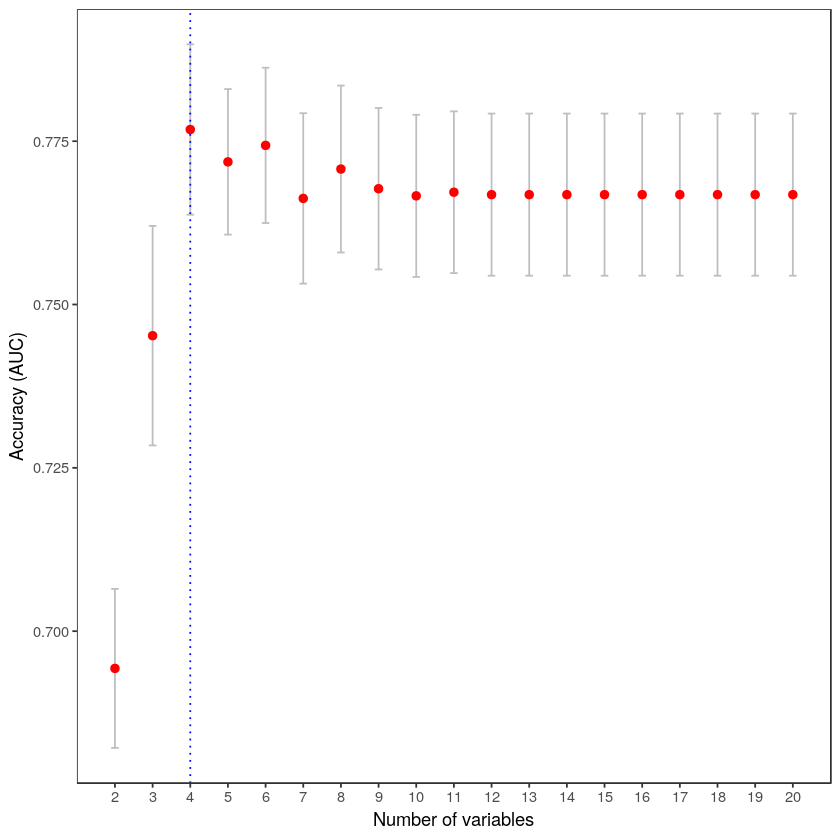

$accuracy.nvar

$var.barplot

$global.plot
TableGrob (2 x 2) "arrange": 4 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]
3 3 (2-2,1-1) arrange gtable[layout]
4 4 (2-2,2-2) arrange gtable[layout]

$global.plot2
TableGrob (3 x 1) "arrange": 3 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (2-2,1-1) arrange gtable[layout]
3 3 (3-3,1-1) arrange gtable[layout]

$ROC.plot

$cv.tab
                 % Global   V9   V2   V6
Fusobacteria   100    DEN  DEN  DEN  DEN
Firmicutes      90    NUM  NUM  NUM  NUM
Chordata        82    DEN  DEN  DEN    0
Bacteroidetes   82    DEN  DEN    0  DEN
Spirochaetes    16      0    0  NUM    0
Proteobacteria   6      0    0    0  DEN
FREQ             -      - 0.66 0.06 0.04

$cv.accuracy
 [1] 0.8055556 0.7435897 0.8148148 0.6833333 0.7314815 0.8425926 0.8461538
 [8] 0.7870370 0.9166667 0.7037037 0.7592593 0.7478632 0.7777778 0.7166667
[15] 0.6944444 0.768518

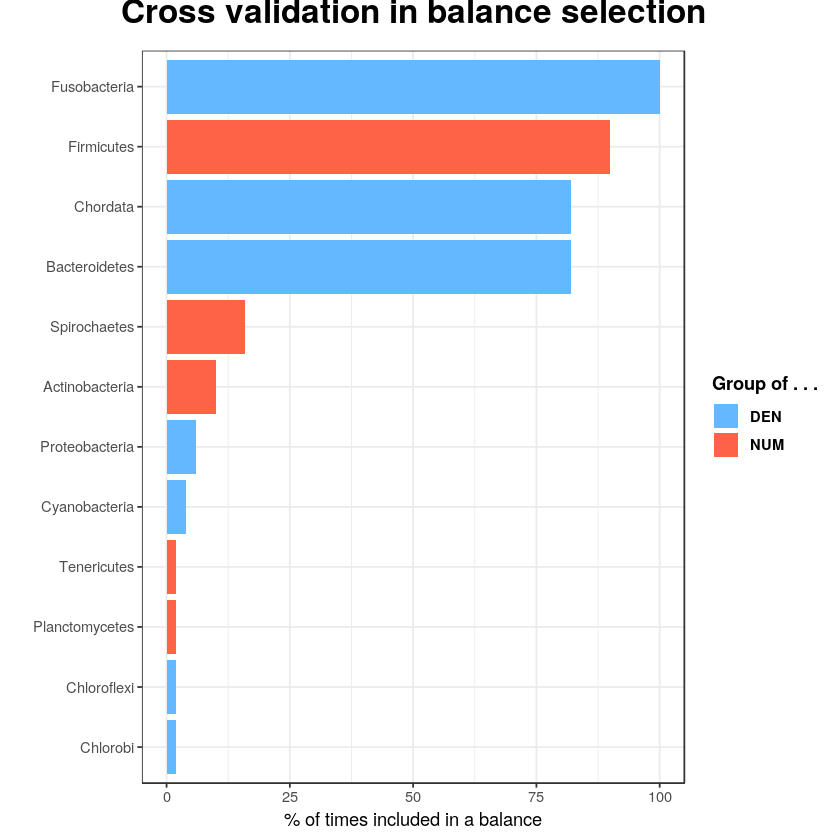

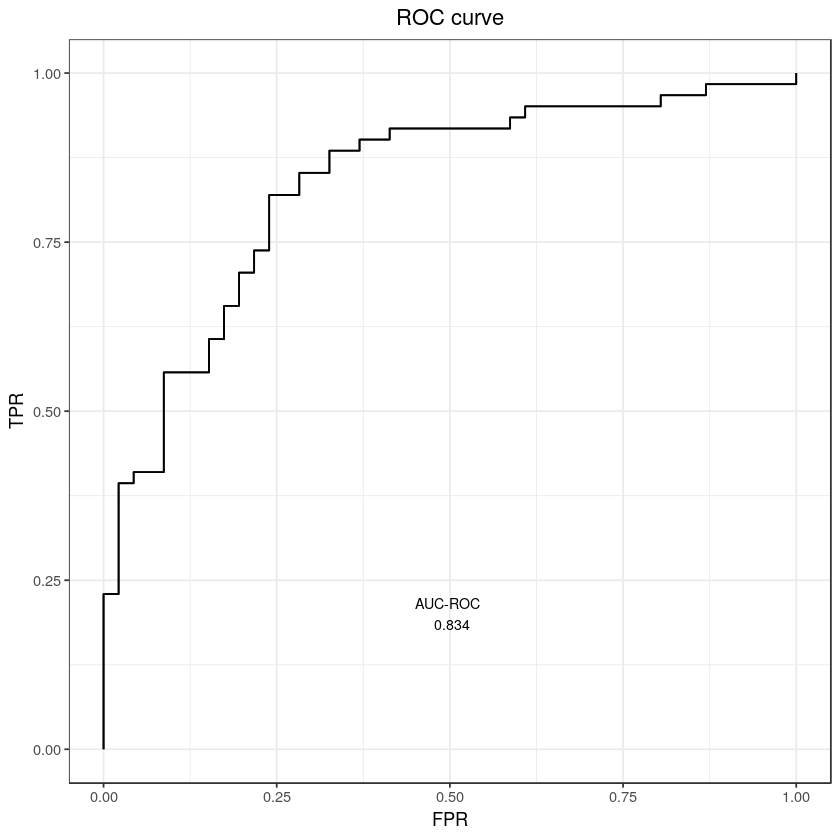

In [11]:
run_selbal("FengQ_2015", "kraken2", "P")

[1] "Reading file"
[1] "df ready"
[1] "df_g ready."
[1] "pivot started...."
[1] "Pivot ready."
[1] "Merge ready."
[1] "x ready."
[1] "y ready."
[1] "x2 un-zerod."
[1] "x2 ready."
[1] "Selbal started."


############################################################### 
 STARTING selbal.cv FUNCTION 
###############################################################

#-------------------------------------------------------------# 
# ZERO REPLACEMENT . . .


, . . . FINISHED. 
#-------------------------------------------------------------#

#-------------------------------------------------------------# 
# Starting the cross - validation procedure . . .
 . . . finished. 
#-------------------------------------------------------------# 
###############################################################

 The optimal number of variables is: 3 


 MUHAHAHAHA runtime stuff
 MUHAHAHAHA final balance calcToday is 

Numy is 
1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 

Setting levels: control = CRC, case = control
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


AUC is 
0.747Fitted_values is 
0.678638473063079 0.762704042372363 0.678638473063079 0.762803476040002 0.360681290432994 0.360563031440729 0.360622173346995 0.360547598440944 0.263243501717133 0.263243501717133 0.263178237987095 0.262982382933005 0.597904071053934 0.598024703725798 0.597783542622049 0.597843793714228 0.639342034496663 0.639301551005758 0.64129905830963 0.589355274586506 0.288731450205395 0.288624554726721 0.288758194381407 0.28865126644724 0.619108180187556 0.619038075123652 0.61906331498032 0.619178320240053 0.642626387446229 0.642492426702403 0.642575264164066 0.642658150385076 0.453248712622539 0.453248712622539 0.453248712622539 0.453248712622539 0.581284040961249 0.453248712622539 0.453248712622539 0.581053658142956 0.59934578820454 0.412043532961708 0.506012003852942 0.506012003852942 0.449288164593695 0.449264702610925 0.449405413975272 0.449288164587965 0.630862708966528 0.630862708966528 0.630862708966528 0.630862708966528 0.54403047409465 0.543602891155935 0.

Setting levels: control = CRC, case = control
Setting direction: controls < cases


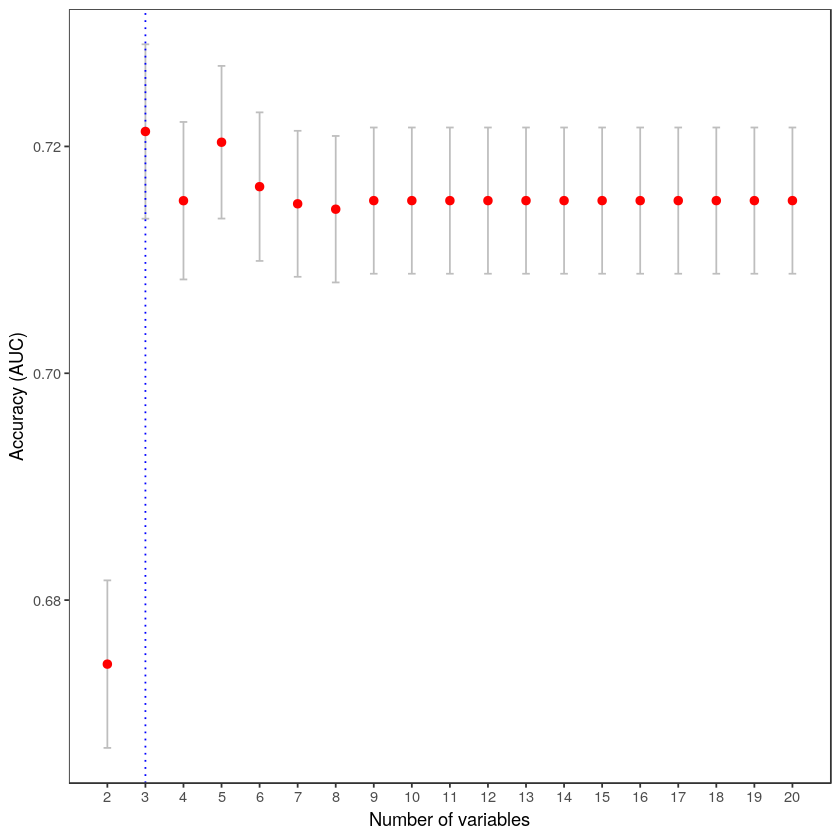

$accuracy.nvar

$var.barplot

$global.plot
TableGrob (2 x 2) "arrange": 4 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]
3 3 (2-2,1-1) arrange gtable[layout]
4 4 (2-2,2-2) arrange gtable[layout]

$global.plot2
TableGrob (3 x 1) "arrange": 3 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (2-2,1-1) arrange gtable[layout]
3 3 (3-3,1-1) arrange gtable[layout]

$ROC.plot

$cv.tab
                 % Global  V3   V4   V5
Tenericutes    100    NUM NUM  NUM  NUM
Chordata        88    DEN DEN  DEN  DEN
Synergistetes   62    DEN DEN    0    0
Fusobacteria    24      0   0    0  DEN
Proteobacteria  18      0   0  DEN    0
FREQ             -      - 0.6 0.12 0.12

$cv.accuracy
 [1] 0.8049887 0.6609977 0.6853741 0.5934959 0.7691850 0.6601474 0.7358277
 [8] 0.7429138 0.7595819 0.7668055 0.7519841 0.7431973 0.6581633 0.7897793
[15] 0.7911957 0.6284014 0.7151361 0.7329932 0.7558072 0.7287329 0.6703

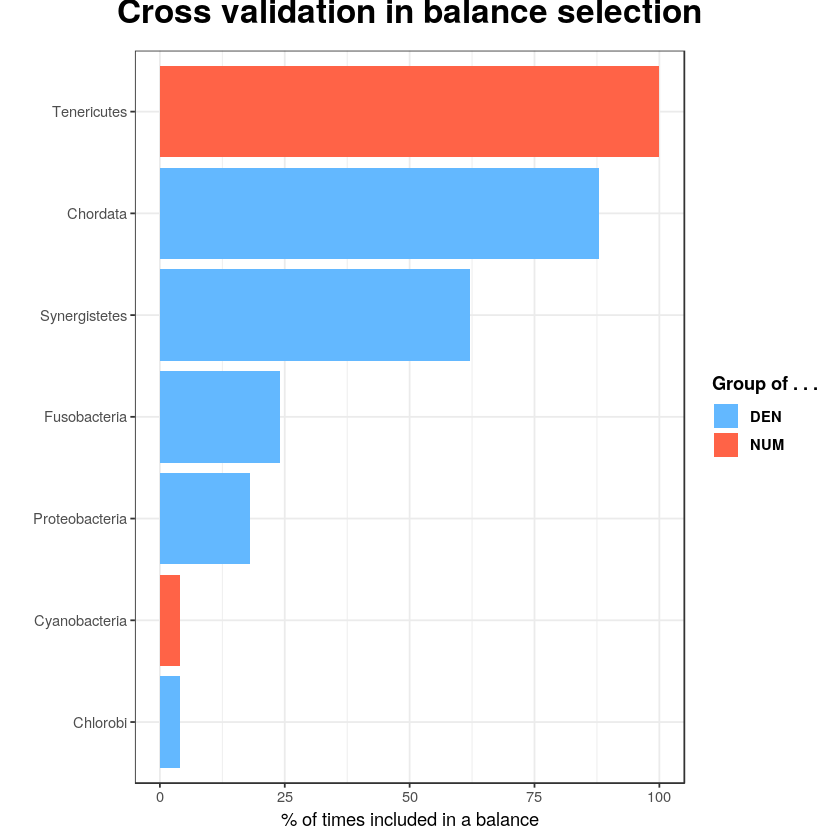

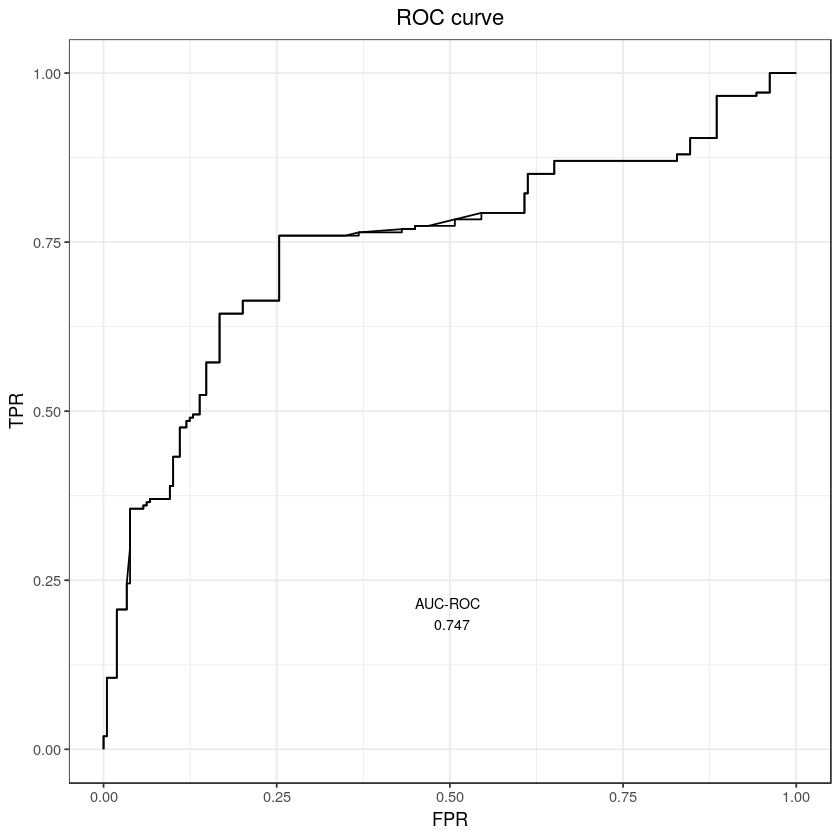

In [12]:
run_selbal("VogtmannE_2016", "kraken2", "P")

[1] "Reading file"
[1] "df ready"
[1] "df_g ready."
[1] "pivot started...."
[1] "Pivot ready."
[1] "Merge ready."
[1] "x ready."
[1] "y ready."
[1] "x2 un-zerod."
[1] "x2 ready."
[1] "Selbal started."


############################################################### 
 STARTING selbal.cv FUNCTION 
###############################################################

#-------------------------------------------------------------# 
# ZERO REPLACEMENT . . .


, . . . FINISHED. 
#-------------------------------------------------------------#

#-------------------------------------------------------------# 
# Starting the cross - validation procedure . . .
 . . . finished. 
#-------------------------------------------------------------# 
###############################################################

 The optimal number of variables is: 3 


 MUHAHAHAHA runtime stuff
 MUHAHAHAHA final balance calcToday is 

Numy is 
1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

Setting levels: control = CRC, case = control
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


AUC is 
0.789Fitted_values is 
0.67156009431406 0.671511308684516 0.671534843386728 0.67097045810209 0.171461803392851 0.155149794603332 0.64009521057261 0.639171383286134 0.640507049131777 0.640166169965856 0.00101923101103561 0.000917947084526736 0.506145783445167 0.50458299494476 0.506884369438497 0.50837067066853 0.585640498979819 0.585923129040317 0.592541055936035 0.593469864507495 0.593999066785163 0.5919857460267 0.69345999274143 0.692538222798608 0.690913545183619 0.692447413324419 0.447818646239699 0.453177021534655 0.690463636980824 0.684647231021782 0.68750755769432 0.685037971400076 0.610423197159553 0.608084360298817 0.610347668227588 0.607429899875727 0.619680366589587 0.618182283946183 0.61877732479654 0.621207722132354 0.642718794366174 0.641354069670681 0.642375590847115 0.643452594390364 0.46936070713543 0.469007069158143 0.00690718701624962 0.00710804646276104 0.332489173287198 0.191950790583579 0.164552423744121 0.208464076758139 0.6843546406329 0.682792001391769 0

Setting levels: control = CRC, case = control
Setting direction: controls < cases


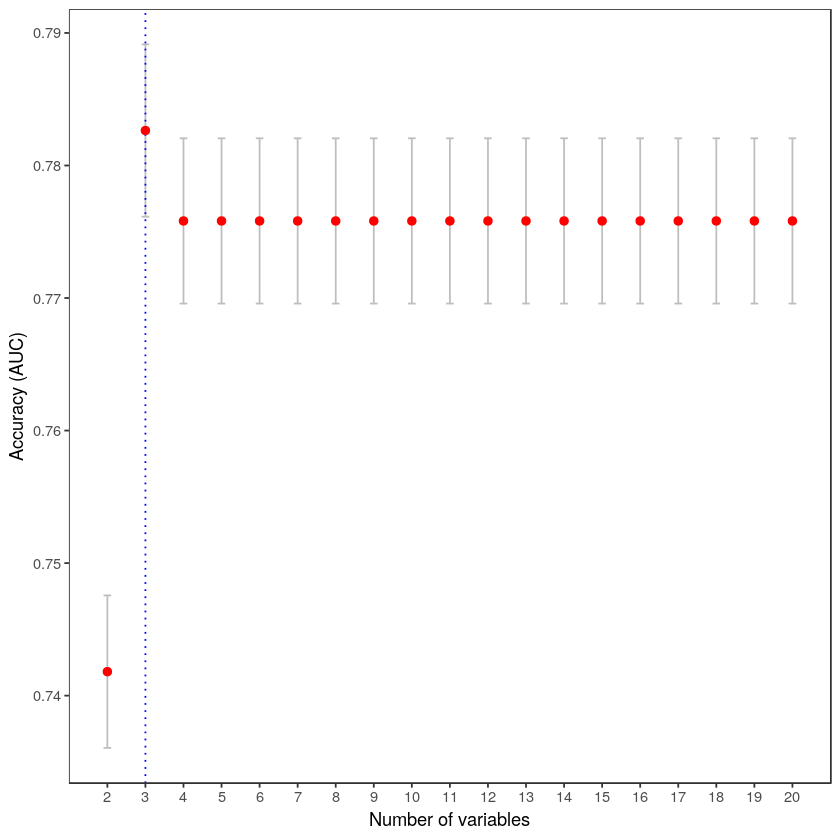

$accuracy.nvar

$var.barplot

$global.plot
TableGrob (2 x 2) "arrange": 4 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]
3 3 (2-2,1-1) arrange gtable[layout]
4 4 (2-2,2-2) arrange gtable[layout]

$global.plot2
TableGrob (3 x 1) "arrange": 3 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (2-2,1-1) arrange gtable[layout]
3 3 (3-3,1-1) arrange gtable[layout]

$ROC.plot

$cv.tab
                 % Global   V2   V1
Firmicutes     100    NUM  NUM  NUM
Fusobacteria   100    DEN  DEN  DEN
Actinobacteria  94    NUM  NUM    0
Bacteroidetes    6      0    0  DEN
FREQ             -      - 0.94 0.06

$cv.accuracy
 [1] 0.8195621 0.7810734 0.7531915 0.7319149 0.8548729 0.7754237 0.7665960
 [8] 0.8617021 0.8046099 0.7362288 0.7454096 0.7786017 0.8326241 0.7180851
[15] 0.7577684 0.8110876 0.7612994 0.7599291 0.6953901 0.8142655 0.7595339
[22] 0.8082627 0.7804965 0.8205674 0.7736582 0.7436441 0.808

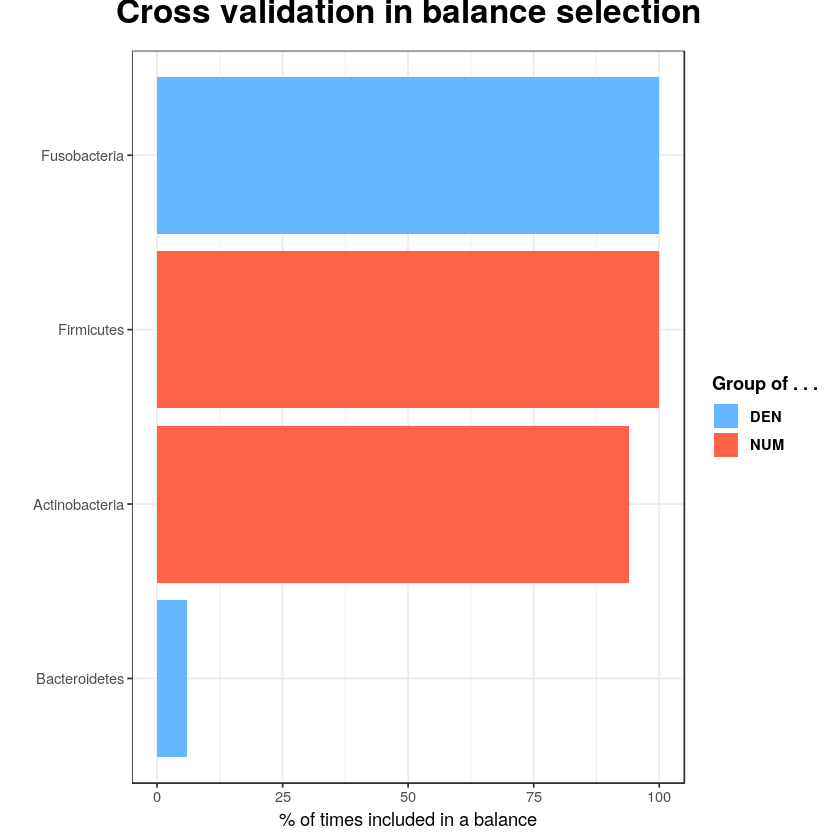

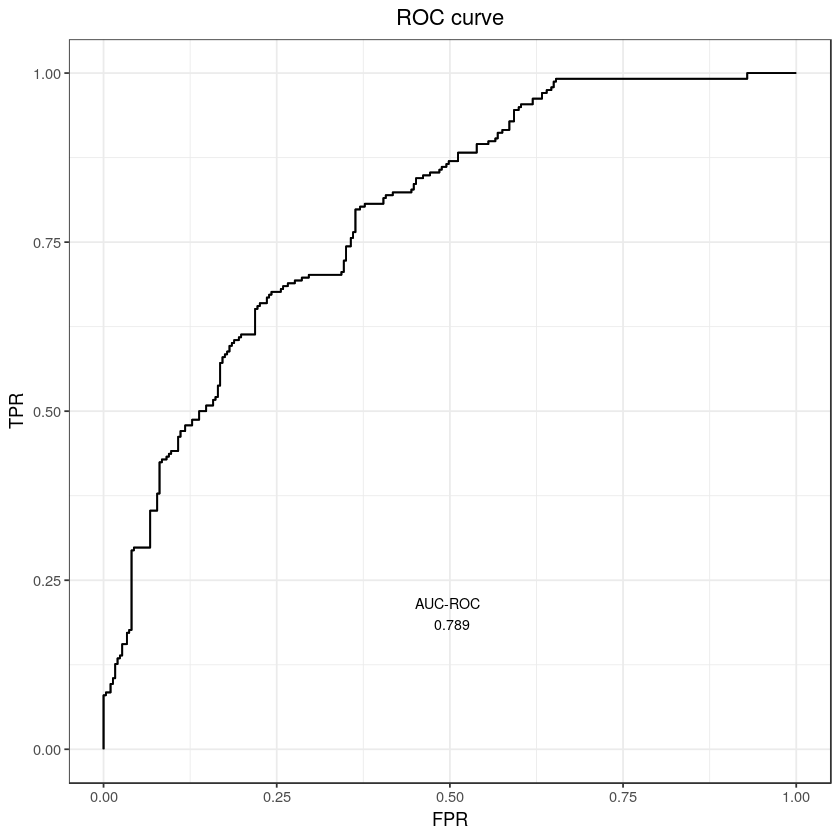

In [88]:
run_selbal("ZellerG_2014", "metaphlan2", "p")

[1] "Reading file"
[1] "df ready"
[1] "df_g ready."
[1] "pivot started...."
[1] "Pivot ready."
[1] "Merge ready."
[1] "x ready."
[1] "y ready."
[1] "x2 un-zerod."
[1] "x2 ready."
[1] "Selbal started."


############################################################### 
 STARTING selbal.cv FUNCTION 
###############################################################

#-------------------------------------------------------------# 
# ZERO REPLACEMENT . . .


, . . . FINISHED. 
#-------------------------------------------------------------#

#-------------------------------------------------------------# 
# Starting the cross - validation procedure . . .
 . . . finished. 
#-------------------------------------------------------------# 
###############################################################

 The optimal number of variables is: 17 


 MUHAHAHAHA runtime stuff
 MUHAHAHAHA final balance calcToday is 

Numy is 
1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1

Setting levels: control = CRC, case = control
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


AUC is 
0.93Fitted_values is 
0.900696885653838 0.746927747132029 0.780248542280954 0.901431632344674 0.274234694524068 0.260589639668738 0.789833834443248 0.837539284594671 0.759298203665394 0.851797925791013 0.000275080251109267 0.000287016518961908 0.99277906074735 0.992917355172626 0.993351967841927 0.991933568797504 0.852819524449221 0.839361397752246 0.934312842132405 0.952664321178947 0.902958716894983 0.907692413568582 0.674837700095467 0.846955214364871 0.677634173061343 0.836893890373132 0.0317306344858044 0.0425788553507903 0.91672745378303 0.877794387313055 0.877717860021668 0.872625098683286 0.886770100321085 0.850390330028684 0.892492799844864 0.891142500310963 0.978169424714086 0.980160958796481 0.986229958329792 0.976981413240617 0.808756749327278 0.907426336336161 0.922278486222257 0.901578334228197 0.993019764922393 0.990735270413616 1.32036852589053e-05 1.26900911911449e-05 0.822072180293381 0.734553279544672 0.587848666517537 0.730628138837622 0.71877739582837 0.813

Setting levels: control = CRC, case = control
Setting direction: controls < cases


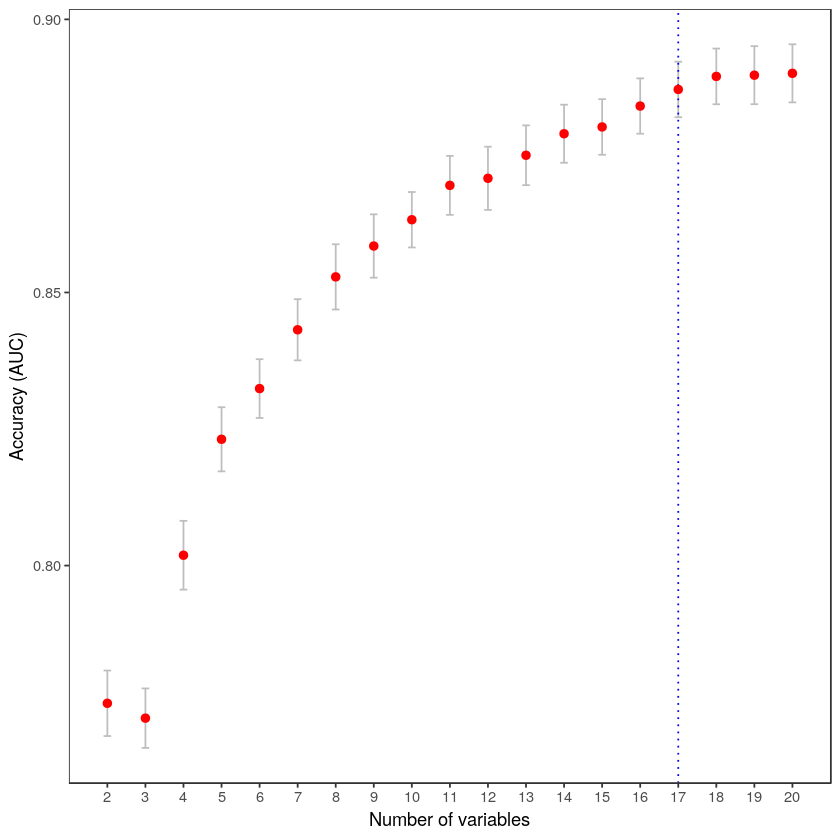

$accuracy.nvar

$var.barplot

$global.plot
TableGrob (2 x 2) "arrange": 4 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]
3 3 (2-2,1-1) arrange gtable[layout]
4 4 (2-2,2-2) arrange gtable[layout]

$global.plot2
TableGrob (3 x 1) "arrange": 3 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (2-2,1-1) arrange gtable[layout]
3 3 (3-3,1-1) arrange gtable[layout]

$ROC.plot

$cv.tab
                                                        % Global  V28   V1   V2
Fusobacterium                                         100    DEN  DEN  DEN  DEN
Lactobacillus                                         100    NUM  NUM  NUM  NUM
Pseudoflavonifractor                                  100    DEN  DEN  DEN  DEN
Peptostreptococcus                                     98    DEN  DEN  DEN  DEN
Sutterella                                             86    NUM  NUM  NUM  NUM
Eubacterium                        

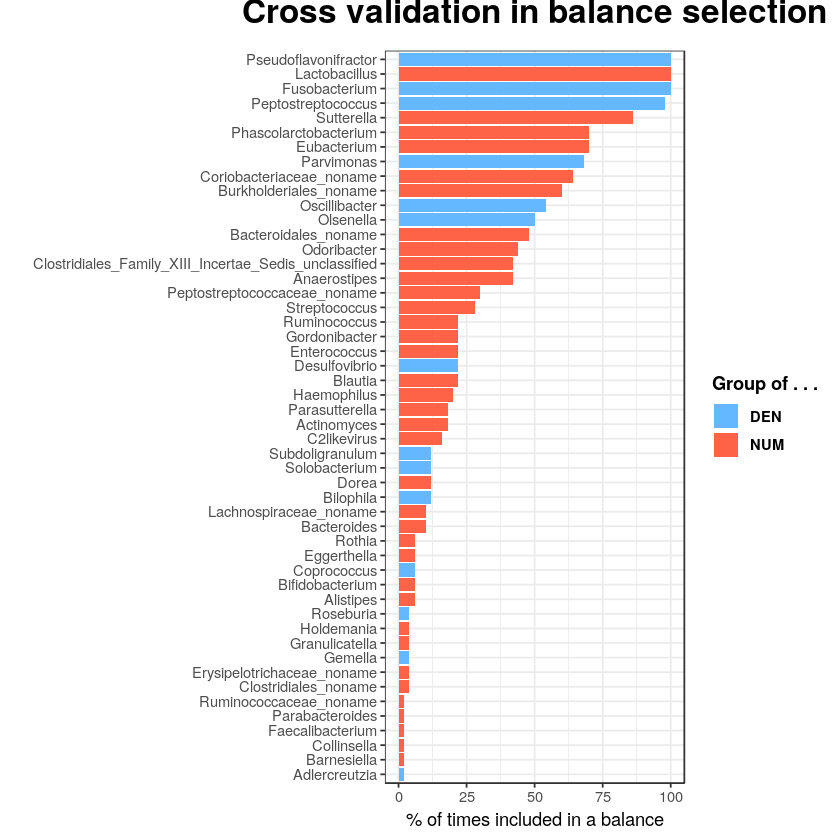

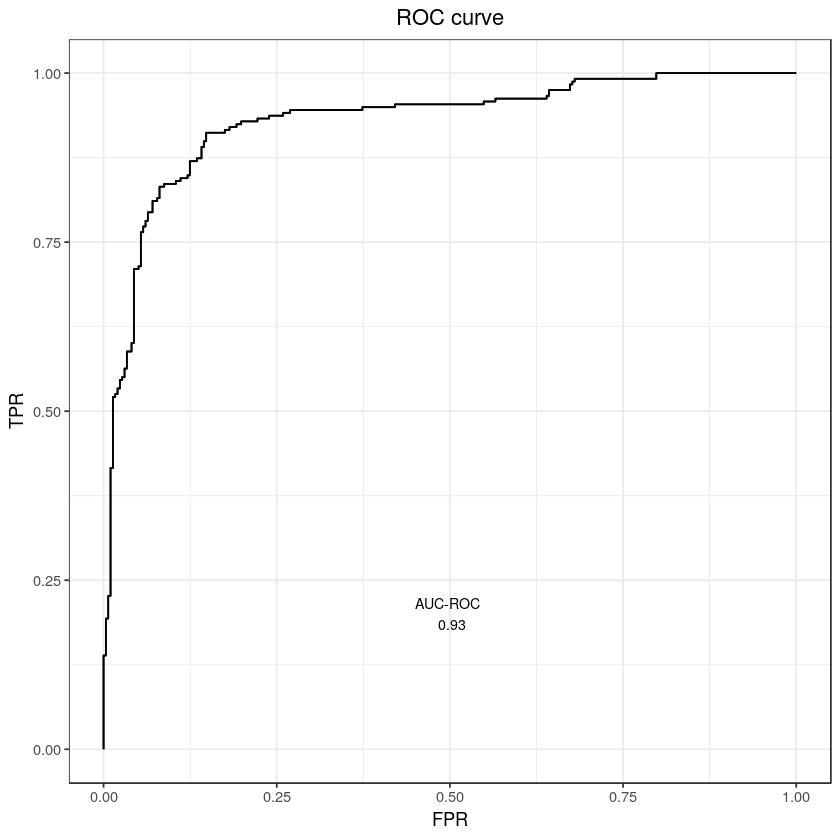

In [91]:
run_selbal("ZellerG_2014", "metaphlan2", "g")

[1] "Reading file"
[1] "df ready"
[1] "df_g ready."
[1] "pivot started...."
[1] "Pivot ready."
[1] "Merge ready."
[1] "x ready."
[1] "y ready."
[1] "x2 un-zerod."
[1] "x2 ready."
[1] "Selbal started."


############################################################### 
 STARTING selbal.cv FUNCTION 
###############################################################

#-------------------------------------------------------------# 
# ZERO REPLACEMENT . . .


, . . . FINISHED. 
#-------------------------------------------------------------#

#-------------------------------------------------------------# 
# Starting the cross - validation procedure . . .
 . . . finished. 
#-------------------------------------------------------------# 
###############################################################

 The optimal number of variables is: 13 


 MUHAHAHAHA runtime stuff
 MUHAHAHAHA final balance calcToday is 

Numy is 
1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1

Setting levels: control = CRC, case = control
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


AUC is 
0.92Fitted_values is 
0.568976021960023 0.567984357731431 0.571446545587427 0.570853093633099 0.383255427231484 0.374202358424209 0.719417251257517 0.717707978928186 0.717379758989115 0.61291649452877 0.0289273711936002 0.0417738523024989 0.501504135692121 0.512370610666134 0.448145635639751 0.336796704029267 0.963928730087882 0.963105307331373 0.772867643384595 0.78105755308043 0.774616831416538 0.773916491913147 0.931357520822861 0.933172089289931 0.93206649016959 0.931235806206873 0.0548836977349804 0.0315692142605683 0.905424351028444 0.905011188462838 0.898910161156113 0.905225112841454 0.856004462634188 0.931504845790611 0.850501822764479 0.928644486277934 0.895482184812028 0.895369441898319 0.947044824818972 0.896196656768094 0.221799903393703 0.222515160088396 0.2257239186489 0.22564556433187 0.976302433524633 0.974212777962639 0.00107582973092091 0.00110798728913471 0.692420212799264 0.672844204753081 0.677159584782092 0.545080423415503 0.992073225381545 0.989303402589

Setting levels: control = CRC, case = control
Setting direction: controls < cases


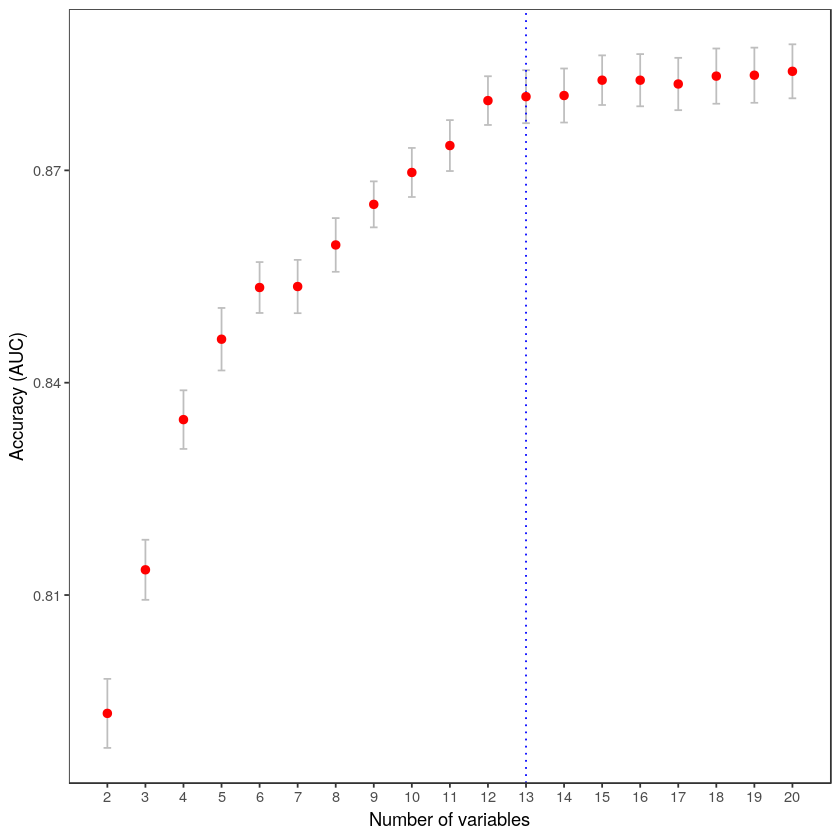

$accuracy.nvar

$var.barplot

$global.plot
TableGrob (2 x 2) "arrange": 4 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]
3 3 (2-2,1-1) arrange gtable[layout]
4 4 (2-2,2-2) arrange gtable[layout]

$global.plot2
TableGrob (3 x 1) "arrange": 3 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (2-2,1-1) arrange gtable[layout]
3 3 (3-3,1-1) arrange gtable[layout]

$ROC.plot

$cv.tab
                     % Global  V44   V1   V2
Eubacterium         98    NUM  NUM  NUM  NUM
Lactobacillus       92    NUM  NUM  NUM  NUM
Actinomyces         90    NUM  NUM    0    0
Faecalitalea        84    DEN  DEN    0  DEN
Anaerostipes        82    NUM  NUM  NUM  NUM
Porphyromonas       82    DEN  DEN  DEN    0
Fusobacterium       74    DEN    0  DEN  DEN
Parvimonas          62    DEN  DEN  DEN    0
Flavonifractor      58    DEN    0    0  DEN
Flavobacterium      56      0  NUM  NUM    0
Lachnoanaerobaculum 

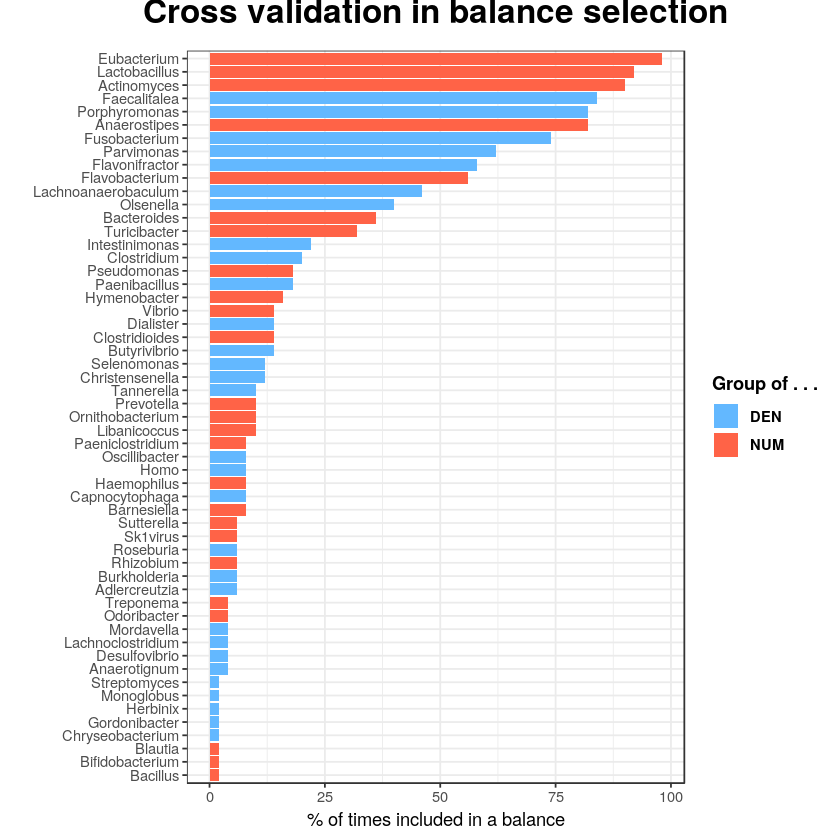

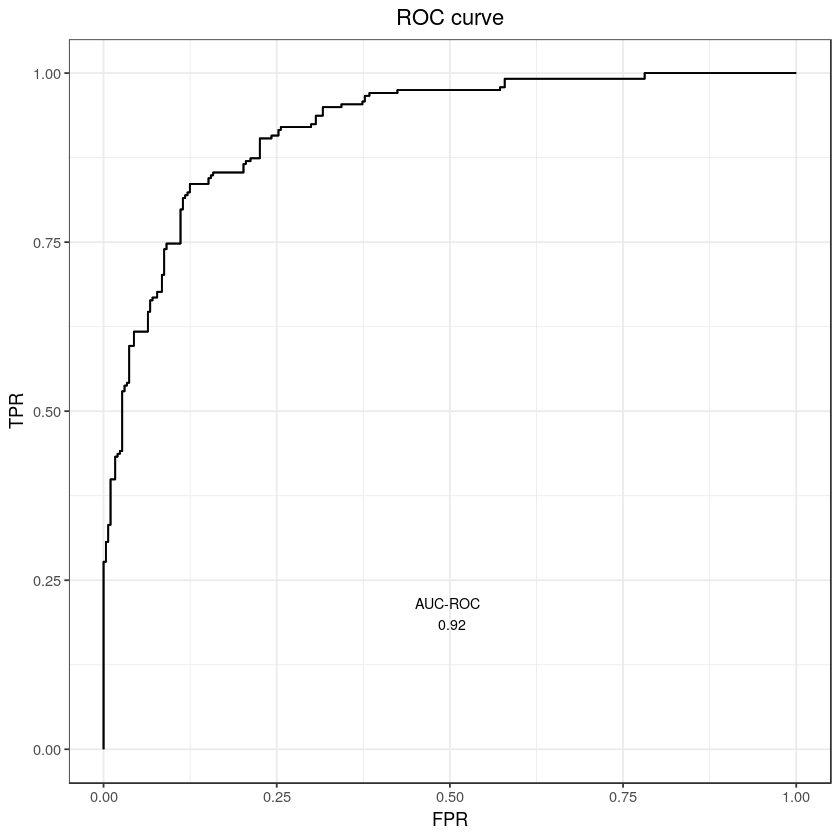

In [92]:
run_selbal("ZellerG_2014", "kraken2", "G")

In [ ]:
compare_balance("FengQ_2015","ZellerG_2014",  "kraken2", "P")
compare_balance("VogtmannE_2016","ZellerG_2014",  "kraken2", "P")

compare_balance("FengQ_2015","ZellerG_2014",  "metaphlan2", "p")
compare_balance("VogtmannE_2016","ZellerG_2014",  "metaphlan2", "p")

compare_balance("FengQ_2015","ZellerG_2014",  "kraken2", "G")

[1] "Reading file"
[1] "df ready"
[1] "df_g ready."
[1] "pivot started...."
[1] "Pivot ready."
[1] "Merge ready."
[1] "x ready."
[1] "y ready."
[1] "x2 un-zerod."
[1] "x2 ready."
[1] "Selbal started."


############################################################### 
 STARTING selbal.cv FUNCTION 
###############################################################

#-------------------------------------------------------------# 
# ZERO REPLACEMENT . . .


, . . . FINISHED. 
#-------------------------------------------------------------#

#-------------------------------------------------------------# 
# Starting the cross - validation procedure . . .
 . . . finished. 
#-------------------------------------------------------------# 
###############################################################

 The optimal number of variables is: 4 


 MUHAHAHAHA runtime stuff
 MUHAHAHAHA final balance calcToday is 

Numy is 
0 1 1 1 1 1 0 1 0 1 0 1 0 1 0 0 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 1 1 0 1 1 0 1 1 1 

Setting levels: control = CRC, case = control
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


AUC is 
0.834Fitted_values is 
0.707662931593135 0.534648513338984 0.795380048443434 0.772284199537448 0.575955633669163 0.825723810008764 0.266389605229312 0.786413390174819 0.364145472980523 0.803419501915723 0.259274687797797 0.637492941124014 0.785545333193746 0.683735078222103 0.425435000739088 0.329531923434352 0.508703203749303 0.576796817562723 0.813814226754729 0.751451477989034 0.599123913946112 0.540800395835608 0.881633312630929 0.801205441354251 0.879555855790988 0.345534258371345 0.116936519650255 0.677186282694084 0.532005292976268 0.672959174862489 0.809977152322866 0.579659454294059 0.866892830900403 0.529608075473335 0.841468883791143 0.952261217930762 0.317579036036275 0.623446647508785 0.951293062682691 0.875624765744467 0.772659320341929 0.68212330567099 0.493524194840711 0.858959111822354 0.424313519582593 0.482635421780936 0.11254457764516 0.4121299740452 0.792971389297118 0.782916147419371 0.414701730696386 0.131507270148492 0.0369476623235299 0.352492209639849 

Setting levels: control = CRC, case = control
Setting direction: controls < cases


[1] "Reading file"
[1] "df ready"
[1] "df_g ready."
[1] "pivot started...."
[1] "Pivot ready."
[1] "Merge ready."
[1] "x ready."
[1] "y ready."
[1] "x2 un-zerod."
[1] "x2 ready."
[1] "Selbal started."


############################################################### 
 STARTING selbal.cv FUNCTION 
###############################################################

#-------------------------------------------------------------# 
# ZERO REPLACEMENT . . .


, . . . FINISHED. 
#-------------------------------------------------------------#

#-------------------------------------------------------------# 
# Starting the cross - validation procedure . . .
 . . . finished. 
#-------------------------------------------------------------# 
###############################################################

 The optimal number of variables is: 7 


 MUHAHAHAHA runtime stuff
 MUHAHAHAHA final balance calcToday is 

Numy is 
1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

Setting levels: control = CRC, case = control
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


AUC is 
0.825Fitted_values is 
0.708442086163888 0.706321959700998 0.705551326091814 0.70652282740415 0.497308683394945 0.496918627865534 0.597998420466398 0.599413395243718 0.599496269943913 0.599661886707667 0.0128201800247991 0.0130769899820885 0.374471318264385 0.374284586728272 0.536227726832109 0.37445836683769 0.448034816637858 0.443316256020293 0.942936310060569 0.943086969444655 0.942662418885707 0.942376485368613 0.834425086865974 0.664001730187875 0.661639105233709 0.661846823692778 0.140652210479034 0.144598320252918 0.896780548197427 0.896617942921217 0.896271593811399 0.896184048033223 0.31900066240338 0.316740741616192 0.316740741616192 0.316187901249458 0.616548383316228 0.618119263563194 0.616162416582783 0.728487692175096 0.767672061742339 0.535806824920843 0.535208632583948 0.535396091191834 0.647779201154586 0.653328165897493 0.0193253468563886 0.0202928323784749 0.234541532665717 0.236304914543435 0.235137571396994 0.235038343784779 0.884820239595221 0.882011538372

Setting levels: control = CRC, case = control
Setting direction: controls < cases
Setting levels: control = CRC, case = control
Setting direction: controls < cases


[1] 0.747
[1] "Reading file"
[1] "df ready"
[1] "df_g ready."
[1] "pivot started...."
[1] "Pivot ready."
[1] "Merge ready."
[1] "x ready."
[1] "y ready."
[1] "x2 un-zerod."
[1] "x2 ready."
[1] "Selbal started."


############################################################### 
 STARTING selbal.cv FUNCTION 
###############################################################

#-------------------------------------------------------------# 
# ZERO REPLACEMENT . . .


, . . . FINISHED. 
#-------------------------------------------------------------#

#-------------------------------------------------------------# 
# Starting the cross - validation procedure . . .
 . . . finished. 
#-------------------------------------------------------------# 
###############################################################

 The optimal number of variables is: 3 


 MUHAHAHAHA runtime stuff
 MUHAHAHAHA final balance calcToday is 

Numy is 
1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 

Setting levels: control = CRC, case = control
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


AUC is 
0.747Fitted_values is 
0.678638473063079 0.762704042372363 0.678638473063079 0.762803476040002 0.360681290432994 0.360563031440729 0.360622173346995 0.360547598440944 0.263243501717133 0.263243501717133 0.263178237987095 0.262982382933005 0.597904071053934 0.598024703725798 0.597783542622049 0.597843793714228 0.639342034496663 0.639301551005758 0.64129905830963 0.589355274586506 0.288731450205395 0.288624554726721 0.288758194381407 0.28865126644724 0.619108180187556 0.619038075123652 0.61906331498032 0.619178320240053 0.642626387446229 0.642492426702403 0.642575264164066 0.642658150385076 0.453248712622539 0.453248712622539 0.453248712622539 0.453248712622539 0.581284040961249 0.453248712622539 0.453248712622539 0.581053658142956 0.59934578820454 0.412043532961708 0.506012003852942 0.506012003852942 0.449288164593695 0.449264702610925 0.449405413975272 0.449288164587965 0.630862708966528 0.630862708966528 0.630862708966528 0.630862708966528 0.54403047409465 0.543602891155935 0.

Setting levels: control = CRC, case = control
Setting direction: controls < cases


[1] "Reading file"
[1] "df ready"
[1] "df_g ready."
[1] "pivot started...."
[1] "Pivot ready."
[1] "Merge ready."
[1] "x ready."
[1] "y ready."
[1] "x2 un-zerod."
[1] "x2 ready."
[1] "Selbal started."


############################################################### 
 STARTING selbal.cv FUNCTION 
###############################################################

#-------------------------------------------------------------# 
# ZERO REPLACEMENT . . .


, . . . FINISHED. 
#-------------------------------------------------------------#

#-------------------------------------------------------------# 
# Starting the cross - validation procedure . . .
 . . . finished. 
#-------------------------------------------------------------# 
###############################################################

 The optimal number of variables is: 7 


 MUHAHAHAHA runtime stuff
 MUHAHAHAHA final balance calcToday is 

Numy is 
1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

Setting levels: control = CRC, case = control
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


AUC is 
0.825Fitted_values is 
0.708442086163888 0.706321959700998 0.705551326091814 0.70652282740415 0.497308683394945 0.496918627865534 0.597998420466398 0.599413395243718 0.599496269943913 0.599661886707667 0.0128201800247991 0.0130769899820885 0.374471318264385 0.374284586728272 0.536227726832109 0.37445836683769 0.448034816637858 0.443316256020293 0.942936310060569 0.943086969444655 0.942662418885707 0.942376485368613 0.834425086865974 0.664001730187875 0.661639105233709 0.661846823692778 0.140652210479034 0.144598320252918 0.896780548197427 0.896617942921217 0.896271593811399 0.896184048033223 0.31900066240338 0.316740741616192 0.316740741616192 0.316187901249458 0.616548383316228 0.618119263563194 0.616162416582783 0.728487692175096 0.767672061742339 0.535806824920843 0.535208632583948 0.535396091191834 0.647779201154586 0.653328165897493 0.0193253468563886 0.0202928323784749 0.234541532665717 0.236304914543435 0.235137571396994 0.235038343784779 0.884820239595221 0.882011538372

Setting levels: control = CRC, case = control
Setting direction: controls < cases
Setting levels: control = CRC, case = control
Setting direction: controls < cases


[1] 0.6279
[1] "Reading file"
[1] "df ready"
[1] "df_g ready."
[1] "pivot started...."
[1] "Pivot ready."
[1] "Merge ready."
[1] "x ready."
[1] "y ready."
[1] "x2 un-zerod."
[1] "x2 ready."
[1] "Selbal started."


############################################################### 
 STARTING selbal.cv FUNCTION 
###############################################################

#-------------------------------------------------------------# 
# ZERO REPLACEMENT . . .


, . . . FINISHED. 
#-------------------------------------------------------------#

#-------------------------------------------------------------# 
# Starting the cross - validation procedure . . .
 . . . finished. 
#-------------------------------------------------------------# 
###############################################################

 The optimal number of variables is: 3 


 MUHAHAHAHA runtime stuff
 MUHAHAHAHA final balance calcToday is 

Numy is 
0 1 1 1 1 1 0 1 0 1 0 1 0 1 0 0 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 1 1 0 1

Setting levels: control = CRC, case = control
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


AUC is 
0.854Fitted_values is 
0.611968806472815 0.636221659577017 0.710726821641102 0.882915003465996 0.818405725998365 0.94152288281991 0.0547728339068545 0.889448853809554 0.165088868735478 0.817181274672901 0.619984298736283 0.694267383168662 0.869806359155526 0.840844406181302 0.800415840566023 0.543697200264187 0.674573983159857 0.620608588174163 0.890978654520082 0.443608344028634 0.650460314327223 0.0542522199321192 0.822119530897255 0.95384943351731 0.886041451387414 0.484411136425545 0.370440575215347 0.755517806344908 0.523449896277608 0.727283714384444 0.93509103752885 0.671794267471188 0.874494251465907 0.797990101475711 0.910720783725485 0.964273482223442 0.679018394025724 0.764546387324034 0.972188237700194 0.945970377601133 0.826993010783615 0.731446798293966 0.724510794251906 0.908811646708497 0.363803779361572 0.173054450307902 0.0197325338396281 0.0321330644275822 0.370816317023442 0.910207110033456 0.58607221977703 0.154072024136409 0.00319550592909008 0.01583197950

Setting levels: control = CRC, case = control
Setting direction: controls < cases


[1] "Reading file"
[1] "df ready"
[1] "df_g ready."
[1] "pivot started...."
[1] "Pivot ready."
[1] "Merge ready."
[1] "x ready."
[1] "y ready."
[1] "x2 un-zerod."
[1] "x2 ready."
[1] "Selbal started."


############################################################### 
 STARTING selbal.cv FUNCTION 
###############################################################

#-------------------------------------------------------------# 
# ZERO REPLACEMENT . . .


, . . . FINISHED. 
#-------------------------------------------------------------#

#-------------------------------------------------------------# 
# Starting the cross - validation procedure . . .
 . . . finished. 
#-------------------------------------------------------------# 
###############################################################

 The optimal number of variables is: 3 


 MUHAHAHAHA runtime stuff
 MUHAHAHAHA final balance calcToday is 

Numy is 
1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

Setting levels: control = CRC, case = control
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


AUC is 
0.789Fitted_values is 
0.67156009431406 0.671511308684516 0.671534843386728 0.67097045810209 0.171461803392851 0.155149794603332 0.64009521057261 0.639171383286134 0.640507049131777 0.640166169965856 0.00101923101103561 0.000917947084526736 0.506145783445167 0.50458299494476 0.506884369438497 0.50837067066853 0.585640498979819 0.585923129040317 0.592541055936035 0.593469864507495 0.593999066785163 0.5919857460267 0.69345999274143 0.692538222798608 0.690913545183619 0.692447413324419 0.447818646239699 0.453177021534655 0.690463636980824 0.684647231021782 0.68750755769432 0.685037971400076 0.610423197159553 0.608084360298817 0.610347668227588 0.607429899875727 0.619680366589587 0.618182283946183 0.61877732479654 0.621207722132354 0.642718794366174 0.641354069670681 0.642375590847115 0.643452594390364 0.46936070713543 0.469007069158143 0.00690718701624962 0.00710804646276104 0.332489173287198 0.191950790583579 0.164552423744121 0.208464076758139 0.6843546406329 0.682792001391769 0

Setting levels: control = CRC, case = control
Setting direction: controls < cases
Setting levels: control = CRC, case = control
Setting direction: controls < cases


[1] 0.7697
[1] "Reading file"
[1] "df ready"
[1] "df_g ready."
[1] "pivot started...."
[1] "Pivot ready."
[1] "Merge ready."
[1] "x ready."
[1] "y ready."
[1] "x2 un-zerod."
[1] "x2 ready."
[1] "Selbal started."


############################################################### 
 STARTING selbal.cv FUNCTION 
###############################################################

#-------------------------------------------------------------# 
# ZERO REPLACEMENT . . .


, . . . FINISHED. 
#-------------------------------------------------------------#

#-------------------------------------------------------------# 
# Starting the cross - validation procedure . . .
 . . . finished. 
#-------------------------------------------------------------# 
###############################################################

 The optimal number of variables is: 2 


 MUHAHAHAHA runtime stuff
 MUHAHAHAHA final balance calcToday is 

Numy is 
1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0

Setting levels: control = CRC, case = control
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


AUC is 
0.661Fitted_values is 
0.562577835679892 0.561890921060053 0.566026355473491 0.562648261328811 0.538238681130425 0.539872884836064 0.538849629369037 0.5390076556517 0.581693333636571 0.582198061683408 0.580984354264636 0.582109016943221 0.561224732094049 0.561463422379184 0.560471191557904 0.561219589252291 0.233152280288411 0.226395639768653 0.227393358898925 0.227760466111678 0.569880096097422 0.570630878190977 0.546043131100069 0.445200143165677 0.575234124234749 0.575584399374745 0.575071258347131 0.574916054764858 0.541041802319385 0.540965259001718 0.540476100053272 0.541663257745142 0.245159720202282 0.251953261929038 0.247514043589857 0.257982111903217 0.544139050501801 0.544601796311969 0.54547996471572 0.544362041893152 0.563754272364275 0.564218263138074 0.563772588160753 0.564404119731562 0.574005248164313 0.5743075885276 0.57397885842228 0.574410127400299 0.570479617430056 0.570176767520259 0.570790691687935 0.570552724342286 0.347500912112741 0.35548783117267 0.32

Setting levels: control = CRC, case = control
Setting direction: controls < cases


[1] "Reading file"
[1] "df ready"
[1] "df_g ready."
[1] "pivot started...."
[1] "Pivot ready."
[1] "Merge ready."
[1] "x ready."
[1] "y ready."
[1] "x2 un-zerod."
[1] "x2 ready."
[1] "Selbal started."


############################################################### 
 STARTING selbal.cv FUNCTION 
###############################################################

#-------------------------------------------------------------# 
# ZERO REPLACEMENT . . .


, . . . FINISHED. 
#-------------------------------------------------------------#

#-------------------------------------------------------------# 
# Starting the cross - validation procedure . . .
 . . . finished. 
#-------------------------------------------------------------# 
###############################################################

 The optimal number of variables is: 3 


 MUHAHAHAHA runtime stuff
 MUHAHAHAHA final balance calcToday is 

Numy is 
1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

Setting levels: control = CRC, case = control
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


AUC is 
0.789Fitted_values is 
0.67156009431406 0.671511308684516 0.671534843386728 0.67097045810209 0.171461803392851 0.155149794603332 0.64009521057261 0.639171383286134 0.640507049131777 0.640166169965856 0.00101923101103561 0.000917947084526736 0.506145783445167 0.50458299494476 0.506884369438497 0.50837067066853 0.585640498979819 0.585923129040317 0.592541055936035 0.593469864507495 0.593999066785163 0.5919857460267 0.69345999274143 0.692538222798608 0.690913545183619 0.692447413324419 0.447818646239699 0.453177021534655 0.690463636980824 0.684647231021782 0.68750755769432 0.685037971400076 0.610423197159553 0.608084360298817 0.610347668227588 0.607429899875727 0.619680366589587 0.618182283946183 0.61877732479654 0.621207722132354 0.642718794366174 0.641354069670681 0.642375590847115 0.643452594390364 0.46936070713543 0.469007069158143 0.00690718701624962 0.00710804646276104 0.332489173287198 0.191950790583579 0.164552423744121 0.208464076758139 0.6843546406329 0.682792001391769 0

Setting levels: control = CRC, case = control
Setting direction: controls < cases
Setting levels: control = CRC, case = control
Setting direction: controls < cases


[1] 0.757
[1] "Reading file"
[1] "df ready"
[1] "df_g ready."
[1] "pivot started...."
[1] "Pivot ready."
[1] "Merge ready."
[1] "x ready."
[1] "y ready."
[1] "x2 un-zerod."
[1] "x2 ready."
[1] "Selbal started."


############################################################### 
 STARTING selbal.cv FUNCTION 
###############################################################

#-------------------------------------------------------------# 
# ZERO REPLACEMENT . . .


, . . . FINISHED. 
#-------------------------------------------------------------#

#-------------------------------------------------------------# 
# Starting the cross - validation procedure . . .
 . . . finished. 
#-------------------------------------------------------------# 
###############################################################

 The optimal number of variables is: 7 


 MUHAHAHAHA runtime stuff
 MUHAHAHAHA final balance calcToday is 

Numy is 
0 1 1 1 1 1 0 1 0 1 0 1 0 1 0 0 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 1 1 0 1 

Setting levels: control = CRC, case = control
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


AUC is 
0.874Fitted_values is 
0.603431857760905 0.556692646866706 0.938577544518404 0.778376260647279 0.738899591750835 0.78280125210219 0.235922593675521 0.77435041881584 0.71708289060158 0.933983693149771 0.422820790647973 0.773144580183407 0.574426579185077 0.897929758778307 0.316451267306635 0.768087468436583 0.949595659128932 0.908252193396978 0.451408810118307 0.235656450019909 0.761258092109961 0.18465130429308 0.749712688698821 0.693330325107107 0.763044161437672 0.482178378741323 0.555208109278224 0.958492905435324 0.300351561756287 0.396351042928043 0.787491687549578 0.576499292527074 0.838795301248943 0.427111615963638 0.798307953500479 0.879963981700269 0.480502077346869 0.843688768548704 0.864263808163229 0.680257386025623 0.541300816750806 0.880354667226072 0.863235129415317 0.771107352580565 0.738677706725263 0.271123246244466 0.111860668547653 0.0130031942173422 0.629988445482757 0.491881683903626 0.759894830705482 0.00468399935793512 0.000759689875656607 0.27402794953

Setting levels: control = CRC, case = control
Setting direction: controls < cases


[1] "Reading file"
[1] "df ready"
[1] "df_g ready."
[1] "pivot started...."
[1] "Pivot ready."
[1] "Merge ready."
[1] "x ready."
[1] "y ready."
[1] "x2 un-zerod."
[1] "x2 ready."
[1] "Selbal started."


############################################################### 
 STARTING selbal.cv FUNCTION 
###############################################################

#-------------------------------------------------------------# 
# ZERO REPLACEMENT . . .


, . . . FINISHED. 
#-------------------------------------------------------------#

#-------------------------------------------------------------# 
# Starting the cross - validation procedure . . .
 . . . finished. 
#-------------------------------------------------------------# 
###############################################################

 The optimal number of variables is: 13 


 MUHAHAHAHA runtime stuff
 MUHAHAHAHA final balance calcToday is 

Numy is 
1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1

Setting levels: control = CRC, case = control
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


AUC is 
0.92Fitted_values is 
0.568976021960023 0.567984357731431 0.571446545587427 0.570853093633099 0.383255427231484 0.374202358424209 0.719417251257517 0.717707978928186 0.717379758989115 0.61291649452877 0.0289273711936002 0.0417738523024989 0.501504135692121 0.512370610666134 0.448145635639751 0.336796704029267 0.963928730087882 0.963105307331373 0.772867643384595 0.78105755308043 0.774616831416538 0.773916491913147 0.931357520822861 0.933172089289931 0.93206649016959 0.931235806206873 0.0548836977349804 0.0315692142605683 0.905424351028444 0.905011188462838 0.898910161156113 0.905225112841454 0.856004462634188 0.931504845790611 0.850501822764479 0.928644486277934 0.895482184812028 0.895369441898319 0.947044824818972 0.896196656768094 0.221799903393703 0.222515160088396 0.2257239186489 0.22564556433187 0.976302433524633 0.974212777962639 0.00107582973092091 0.00110798728913471 0.692420212799264 0.672844204753081 0.677159584782092 0.545080423415503 0.992073225381545 0.989303402589

Setting levels: control = CRC, case = control
Setting direction: controls < cases
Setting levels: control = CRC, case = control
Setting direction: controls < cases


[1] 0.6767


In [95]:
compare_balance("VogtmannE_2016","ZellerG_2014",  "kraken2", "G")

compare_balance("FengQ_2015","ZellerG_2014",  "metaphlan2", "g")
compare_balance("VogtmannE_2016","ZellerG_2014",  "metaphlan2", "g")


compare_balance("ZellerG_2014", "FengQ_2015", "kraken2", "P")
compare_balance("ZellerG_2014", "VogtmannE_2016", "kraken2", "P")

compare_balance("ZellerG_2014", "FengQ_2015", "metaphlan2", "p")
compare_balance("ZellerG_2014", "VogtmannE_2016", "metaphlan2", "p")

compare_balance("ZellerG_2014", "FengQ_2015", "kraken2", "G")
compare_balance("ZellerG_2014", "VogtmannE_2016", "kraken2", "G")

compare_balance("ZellerG_2014", "FengQ_2015", "metaphlan2", "g")
compare_balance("ZellerG_2014", "VogtmannE_2016", "metaphlan2", "g")

[1] "Reading file"
[1] "df ready"
[1] "df_g ready."
[1] "pivot started...."
[1] "Pivot ready."
[1] "Merge ready."
[1] "x ready."
[1] "y ready."
[1] "x2 un-zerod."
[1] "x2 ready."
[1] "Selbal started."


############################################################### 
 STARTING selbal.cv FUNCTION 
###############################################################

#-------------------------------------------------------------# 
# ZERO REPLACEMENT . . .


, . . . FINISHED. 
#-------------------------------------------------------------#

#-------------------------------------------------------------# 
# Starting the cross - validation procedure . . .
 . . . finished. 
#-------------------------------------------------------------# 
###############################################################

 The optimal number of variables is: 16 


 MUHAHAHAHA runtime stuff
 MUHAHAHAHA final balance calcToday is 

Numy is 
1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1

Setting levels: control = CRC, case = control
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


AUC is 
0.889Fitted_values is 
0.79969263494395 0.79578651368625 0.795832804988004 0.795864969988821 0.537894892141739 0.531910321454725 0.651028086637307 0.656610493430911 0.911031898281906 0.911064492920873 0.883702285675898 0.918743749836441 0.832690603885963 0.832690617498521 0.839107985353669 0.875482155944267 0.818899152529574 0.818933647466701 0.818248765133568 0.805058397298764 0.0796149969881986 0.079938446494202 0.0796736898056091 0.079734653269292 0.901741483873494 0.901777127714524 0.761543845174909 0.636609962856744 0.42380882746615 0.423819841559427 0.423834055741548 0.423759076226441 0.00451005907130099 0.00711760226521326 0.00620686265822636 0.00714410729343117 0.763505200785347 0.776953360449352 0.774867439777072 0.560184825089536 0.181750375865323 0.183043668332641 0.183161224365122 0.181835448889355 0.45420971040755 0.319072350033816 0.439032951809774 0.454212855668438 0.987992999235122 0.988038334715327 0.993396812269241 0.988016076631266 0.221988489854709 0.2234645

Setting levels: control = CRC, case = control
Setting direction: controls < cases


[1] "Reading file"
[1] "df ready"
[1] "df_g ready."
[1] "pivot started...."
[1] "Pivot ready."
[1] "Merge ready."
[1] "x ready."
[1] "y ready."
[1] "x2 un-zerod."
[1] "x2 ready."
[1] "Selbal started."


############################################################### 
 STARTING selbal.cv FUNCTION 
###############################################################

#-------------------------------------------------------------# 
# ZERO REPLACEMENT . . .


, . . . FINISHED. 
#-------------------------------------------------------------#

#-------------------------------------------------------------# 
# Starting the cross - validation procedure . . .
 . . . finished. 
#-------------------------------------------------------------# 
###############################################################

 The optimal number of variables is: 13 


 MUHAHAHAHA runtime stuff
 MUHAHAHAHA final balance calcToday is 

Numy is 
1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1

Setting levels: control = CRC, case = control
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


AUC is 
0.92Fitted_values is 
0.568976021960023 0.567984357731431 0.571446545587427 0.570853093633099 0.383255427231484 0.374202358424209 0.719417251257517 0.717707978928186 0.717379758989115 0.61291649452877 0.0289273711936002 0.0417738523024989 0.501504135692121 0.512370610666134 0.448145635639751 0.336796704029267 0.963928730087882 0.963105307331373 0.772867643384595 0.78105755308043 0.774616831416538 0.773916491913147 0.931357520822861 0.933172089289931 0.93206649016959 0.931235806206873 0.0548836977349804 0.0315692142605683 0.905424351028444 0.905011188462838 0.898910161156113 0.905225112841454 0.856004462634188 0.931504845790611 0.850501822764479 0.928644486277934 0.895482184812028 0.895369441898319 0.947044824818972 0.896196656768094 0.221799903393703 0.222515160088396 0.2257239186489 0.22564556433187 0.976302433524633 0.974212777962639 0.00107582973092091 0.00110798728913471 0.692420212799264 0.672844204753081 0.677159584782092 0.545080423415503 0.992073225381545 0.989303402589

Setting levels: control = CRC, case = control
Setting direction: controls < cases


ERROR: Error in `[.data.frame`(logc, , NUM): undefined columns selected
